# Problem Statement
Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

Porter works with a wide range of restaurants for delivering their items directly to the people.

Porter has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.

#### This dataset has the required data to train a regression model that will do the delivery time estimation, based on all those features

# Loading Library

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

# Loading file from link

In [22]:
import requests

# URL of the ZIP file
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/015/039/original/dataset.csv.zip?1663710760"

# Local file path to save the downloaded ZIP
local_filename = "portor.zip"

# Send a GET request to the URL
response = requests.get(url, stream=True)

# Write the content to a local file
with open(local_filename, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

print(f"File downloaded successfully as {local_filename}")


File downloaded successfully as portor.zip


In [23]:
import zipfile

# Path to the ZIP file
zip_file_path = "portor.zip"

# Destination folder to extract contents
extract_to_folder = "extracted_files"

# Open the ZIP file and extract all contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_folder)

print(f"Files extracted to {extract_to_folder}")


Files extracted to extracted_files


In [24]:
df = pd.read_csv("extracted_files/dataset.csv")

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

## Converting columns to required data type for below columns

In [26]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['market_id'] = df['market_id'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('category')
df['store_primary_category'] = df['store_primary_category'].astype('category')
df['day_create'] = df['created_at'].dt.day
df['month_create'] = df['created_at'].dt.month
df['year_create'] = df['created_at'].dt.year
df['day_of_wk_create'] = df['created_at'].dt.dayofweek
df['hr_create'] = df['created_at'].dt.hour
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 196441 non-null  category      
 1   created_at                197428 non-null  datetime64[ns]
 2   actual_delivery_time      197421 non-null  datetime64[ns]
 3   store_id                  197428 non-null  object        
 4   store_primary_category    192668 non-null  category      
 5   order_protocol            196433 non-null  category      
 6   total_items               197428 non-null  int64         
 7   subtotal                  197428 non-null  int64         
 8   num_distinct_items        197428 non-null  int64         
 9   min_item_price            197428 non-null  int64         
 10  max_item_price            197428 non-null  int64         
 11  total_onshift_partners    181166 non-null  float64       
 12  to

In [27]:
# Creating target columns in hours (difference in hours)
df['tar_est_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 3600
df['tar_est_time'].head()

,tar_est_time
0,1.049722
1,1.117778
2,0.494722
3,0.854167
4,0.663889


# EDA
 - 6 columns having null values--> total_onshift_partners, total_busy_partners, total_outstanding_orders, store_primary_category, market_id
 - total of 197428 records are available
 - 14 columns are available
 - 4 columns have data type as 'object' and columns are menetioned below created_at, actual_delivery_time, store_id, store_primary_category
 - day, month, hours, day and week of day columns are created.
 - 2014-10-19 to 2015-02-18 are range of dates from created_id columns

In [20]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,day_create,month_create,year_create,day_of_wk_create,hr_create,tar_est_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,6,2,2015,4,22,1.049722
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,10,2,2015,1,21,1.117778
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,22,1,2015,3,20,0.494722
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,3,2,2015,1,21,0.854167
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,15,2,2015,6,2,0.663889


In [48]:
df.describe()

,created_at,actual_delivery_time,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,day_create,month_create,year_create,day_of_wk_create,hr_create,tar_est_time
count,197428,197421,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197421.000000
mean,2015-02-04 22:00:09.537962752,2015-02-04 22:48:23.348914432,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,15.296721,1.653170,2014.999995,3.218966,8.467213,0.807849
min,2014-10-19 05:24:15,2015-01-21 15:58:11,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,1.000000,1.000000,2014.000000,0.000000,0.000000,0.028056
25%,2015-01-29 02:32:42,2015-01-29 03:22:29,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,7.000000,1.000000,2015.000000,1.000000,2.000000,0.584444
50%,2015-02-05 03:29:09.500000,2015-02-05 04:40:41,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,14.000000,2.000000,2015.000000,3.000000,3.000000,0.738889
75%,2015-02-12 01:39:18.500000,2015-02-12 02:25:26,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,24.000000,2.000000,2015.000000,5.000000,19.000000,0.939167
max,2015-02-18 06:00:44,2015-02-19 22:45:31,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,31.000000,10.000000,2015.000000,6.000000,23.000000,2365.794167
std,NaN,NaN,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,9.200962,0.476345,0.002251,2.045789,8.658759,5.341558


In [49]:
round(df.isnull().sum()/df.shape[0]*100,2).sort_values(ascending=False)

,0
total_busy_partners,8.24
total_outstanding_orders,8.24
total_onshift_partners,8.24
store_primary_category,2.41
order_protocol,0.50
market_id,0.50
created_at,0.00
actual_delivery_time,0.00
store_id,0.00
num_distinct_items,0.00


In [50]:
df.shape

(197428, 20)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 196441 non-null  category      
 1   created_at                197428 non-null  datetime64[ns]
 2   actual_delivery_time      197421 non-null  datetime64[ns]
 3   store_id                  197428 non-null  object        
 4   store_primary_category    192668 non-null  category      
 5   order_protocol            196433 non-null  category      
 6   total_items               197428 non-null  int64         
 7   subtotal                  197428 non-null  int64         
 8   num_distinct_items        197428 non-null  int64         
 9   min_item_price            197428 non-null  int64         
 10  max_item_price            197428 non-null  int64         
 11  total_onshift_partners    181166 non-null  float64       
 12  to

## Univariate Analysis
### Observation found -
 - market_id 2 is count is more
 - Order protorcal 1 and 3, count is high
 - Create_id column, day 18, 19 and 20th are very minimal or data is missing on those days.
 - only Jan, feb and Oct data are available
 - Majority data are from 2015.
 - Sat and sunday have majority of orders
 - 2 hr and 20hr are peak of orders
 - orders are more focued on early in moring and late in evening. Afternoon orders are minimum.
 - All numerical columns are right skewed.
 - All numerical columns have outliers and outlier are removed later in code

In [52]:
col = df.columns
for i in col:
    print('Unique values of',i, 'column =', df[i].nunique())

    print('-----------------------------------------------')

Unique values of market_id column = 6
-----------------------------------------------
Unique values of created_at column = 180985
-----------------------------------------------
Unique values of actual_delivery_time column = 178110
-----------------------------------------------
Unique values of store_id column = 6743
-----------------------------------------------
Unique values of store_primary_category column = 74
-----------------------------------------------
Unique values of order_protocol column = 7
-----------------------------------------------
Unique values of total_items column = 57
-----------------------------------------------
Unique values of subtotal column = 8368
-----------------------------------------------
Unique values of num_distinct_items column = 20
-----------------------------------------------
Unique values of min_item_price column = 2312
-----------------------------------------------
Unique values of max_item_price column = 2652
----------------------------

In [53]:
col = df.columns
for i in col:
    print('Unique values of',i, 'column')
    print((df[i].value_counts().head(3)/df.shape[0]) * 100)
    print('-----------------------------------------------')

Unique values of market_id column
market_id
2.0    27.887635
4.0    24.109549
1.0    19.266264
Name: count, dtype: float64
-----------------------------------------------
Unique values of created_at column
created_at
2015-01-24 01:56:33    0.003039
2015-02-11 19:50:43    0.003039
2015-02-16 01:48:11    0.002533
Name: count, dtype: float64
-----------------------------------------------
Unique values of actual_delivery_time column
actual_delivery_time
2015-02-01 03:44:13    0.002533
2015-02-16 03:51:49    0.002533
2015-02-05 03:10:31    0.002533
Name: count, dtype: float64
-----------------------------------------------
Unique values of store_id column
store_id
d43ab110ab2489d6b9b2caa394bf920f    0.474603
757b505cfd34c64c85ca5b5690ee5293    0.437121
faacbcd5bf1d018912c116bf2783e9a1    0.412809
Name: count, dtype: float64
-----------------------------------------------
Unique values of store_primary_category column
store_primary_category
american    9.825861
pizza       8.773325
mexican 

In [54]:
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'day_create', 'month_create', 'year_create',
       'day_of_wk_create', 'hr_create', 'tar_est_time'],
      dtype='object')

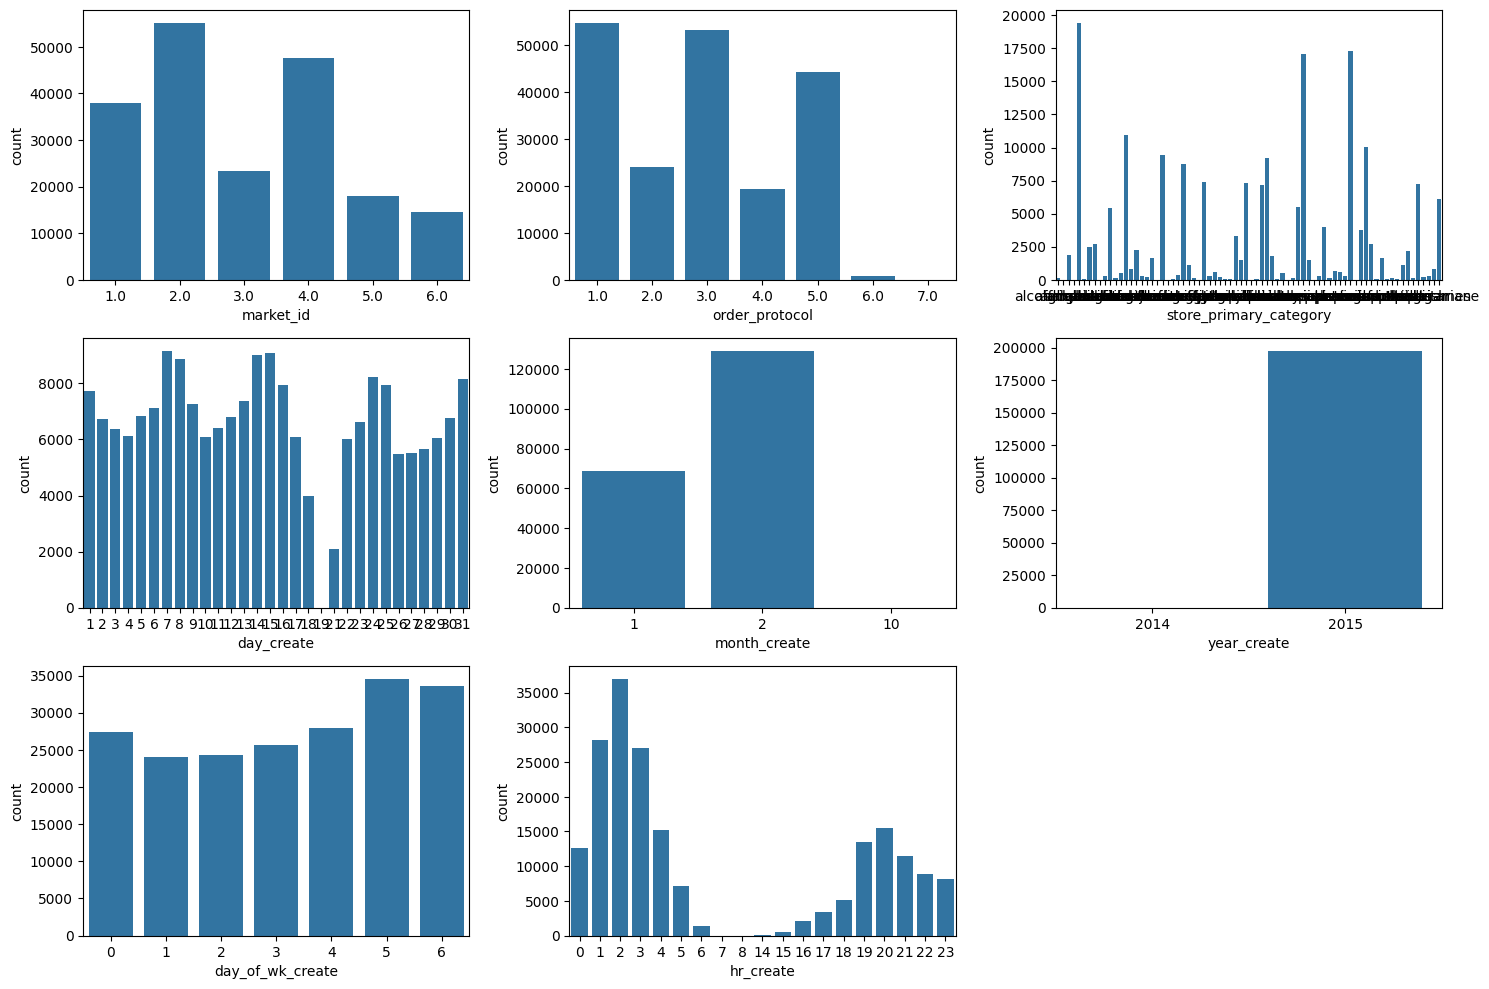

In [55]:
cat_cols = ['market_id', 'order_protocol', 'store_primary_category','day_create', 'month_create', 'year_create', 'day_of_wk_create', 'hr_create']

fig, ax = plt.subplots(3,3, figsize = (15,10))

sns.countplot(ax = ax[0,0], x = df[cat_cols[0]])
sns.countplot(ax = ax[0,1], x = df[cat_cols[1]])
sns.countplot(ax = ax[0,2], x = df[cat_cols[2]])
sns.countplot(ax = ax[1,0], x = df[cat_cols[3]])
sns.countplot(ax = ax[1,1], x = df[cat_cols[4]])
sns.countplot(ax = ax[1,2], x = df[cat_cols[5]])
sns.countplot(ax = ax[2,0], x = df[cat_cols[6]])
sns.countplot(ax = ax[2,1], x = df[cat_cols[7]])
fig.delaxes(ax[2, 2])

plt.tight_layout()
plt.show()

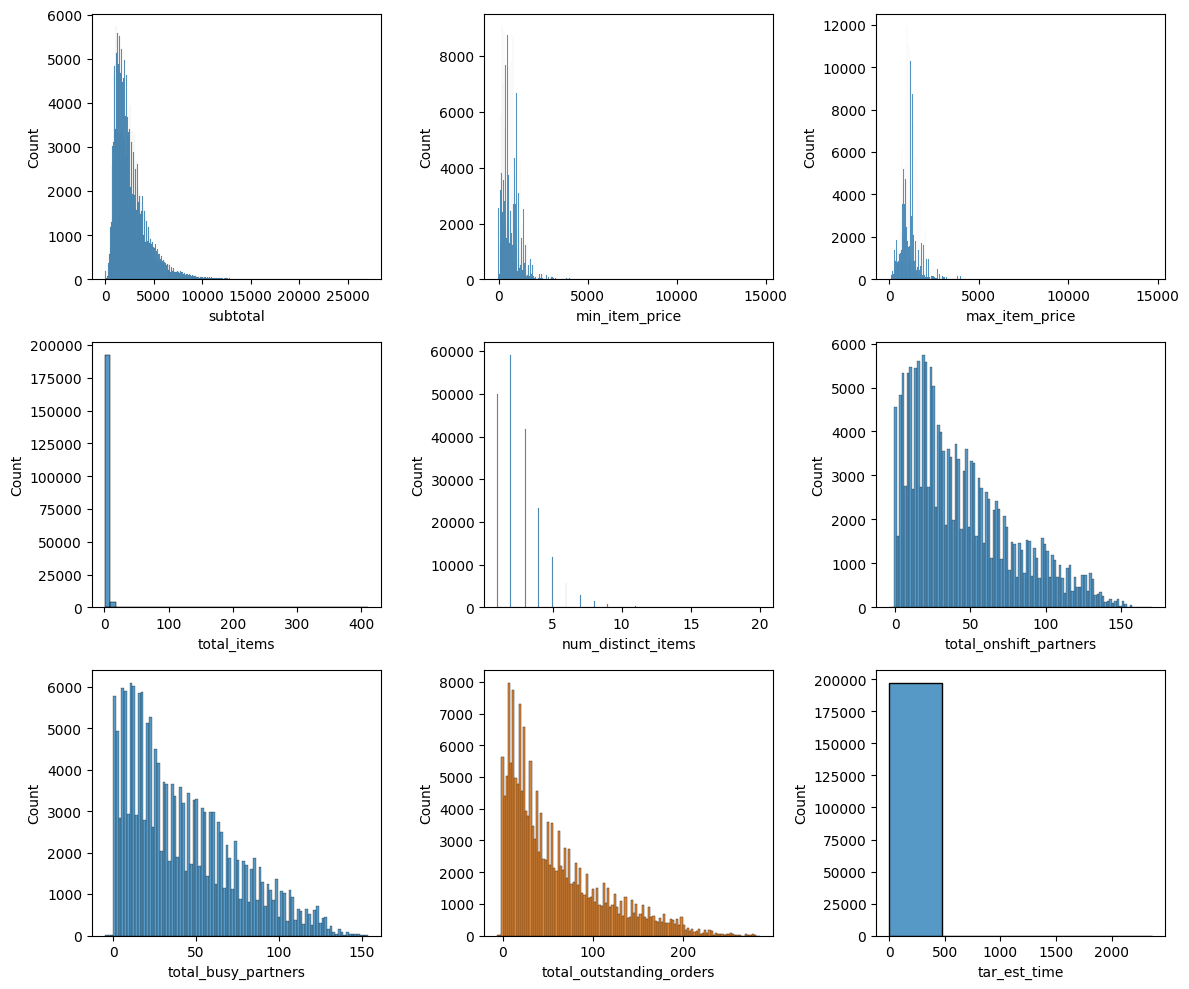

In [ ]:
num_cols = ['subtotal', 'min_item_price', 'max_item_price', 'total_items', 'num_distinct_items', 'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', "tar_est_time"]

fig, ax = plt.subplots(3,3, figsize = (12,10))

sns.histplot(ax = ax[0,0], x = df[num_cols[0]])
sns.histplot(ax = ax[0,1], x = df[num_cols[1]])
sns.histplot(ax = ax[0,2], x = df[num_cols[2]])
sns.histplot(ax = ax[1,0], x = df[num_cols[3]], bins=50)
sns.histplot(ax = ax[1,1], x = df[num_cols[4]])
sns.histplot(ax = ax[1,2], x = df[num_cols[5]])
sns.histplot(ax = ax[2,0], x = df[num_cols[6]])
sns.histplot(ax = ax[2,1], x = df[num_cols[7]])
sns.histplot(ax = ax[2,1], x = df[num_cols[7]])
sns.histplot(ax = ax[2,2], x = df[num_cols[8]], bins=5)
#fig.delaxes(ax[2, 2])

plt.tight_layout()
plt.show()

## Outlier detection:
 - below mentioned columns have outliers

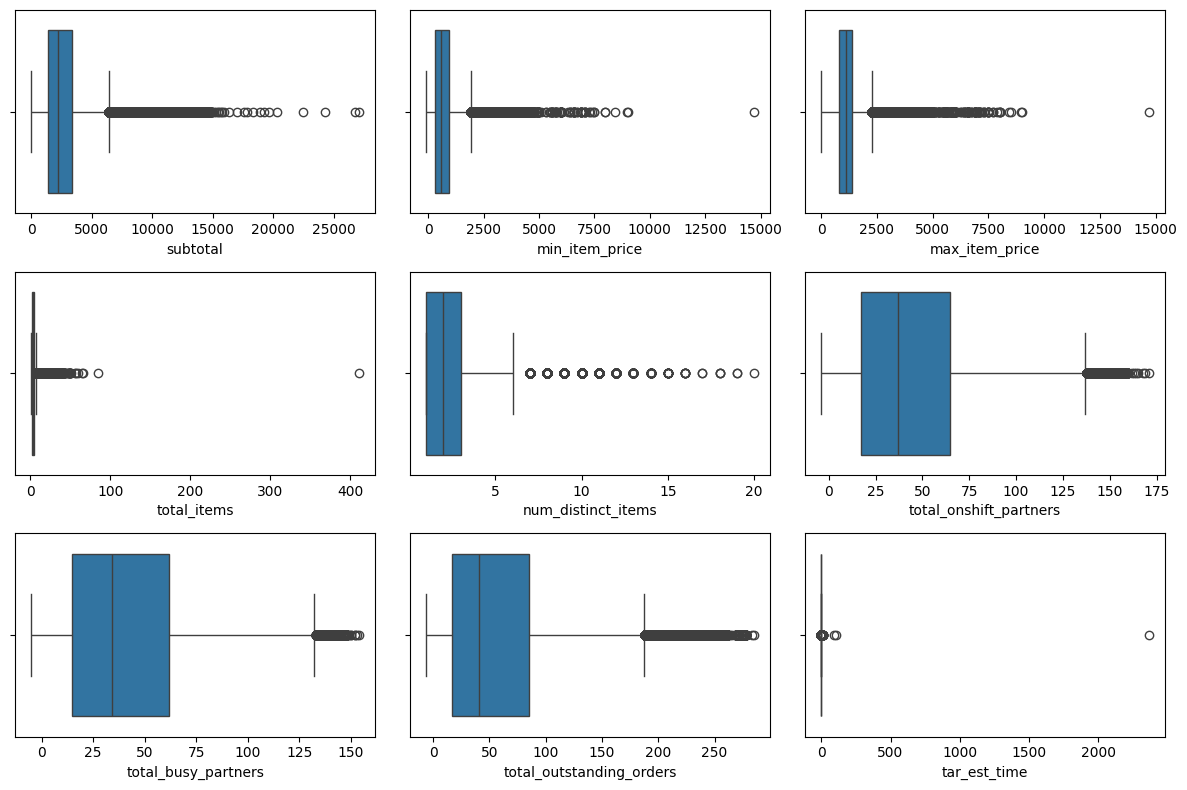

In [56]:
num_cols = ['subtotal', 'min_item_price', 'max_item_price', 'total_items', 'num_distinct_items', 'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'tar_est_time']

fig, ax = plt.subplots(3,3, figsize = (12,8))

sns.boxplot(ax = ax[0,0], x = df[num_cols[0]])
sns.boxplot(ax = ax[0,1], x = df[num_cols[1]])
sns.boxplot(ax = ax[0,2], x = df[num_cols[2]])
sns.boxplot(ax = ax[1,0], x = df[num_cols[3]])
sns.boxplot(ax = ax[1,1], x = df[num_cols[4]])
sns.boxplot(ax = ax[1,2], x = df[num_cols[5]])
sns.boxplot(ax = ax[2,0], x = df[num_cols[6]])
sns.boxplot(ax = ax[2,1], x = df[num_cols[7]])
sns.boxplot(ax = ax[2,2], x = df[num_cols[8]])
#fig.delaxes(ax[2, 2])

plt.tight_layout()
plt.show()

## Removing outlier in each column

In [28]:
num_cols = ['subtotal', 'min_item_price', 'max_item_price', 'total_items', 'num_distinct_items', 'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders','tar_est_time']

for i in num_cols:
  df[i] = df[i].clip(lower=df[i].quantile(0.05), upper=df[i].quantile(0.95))

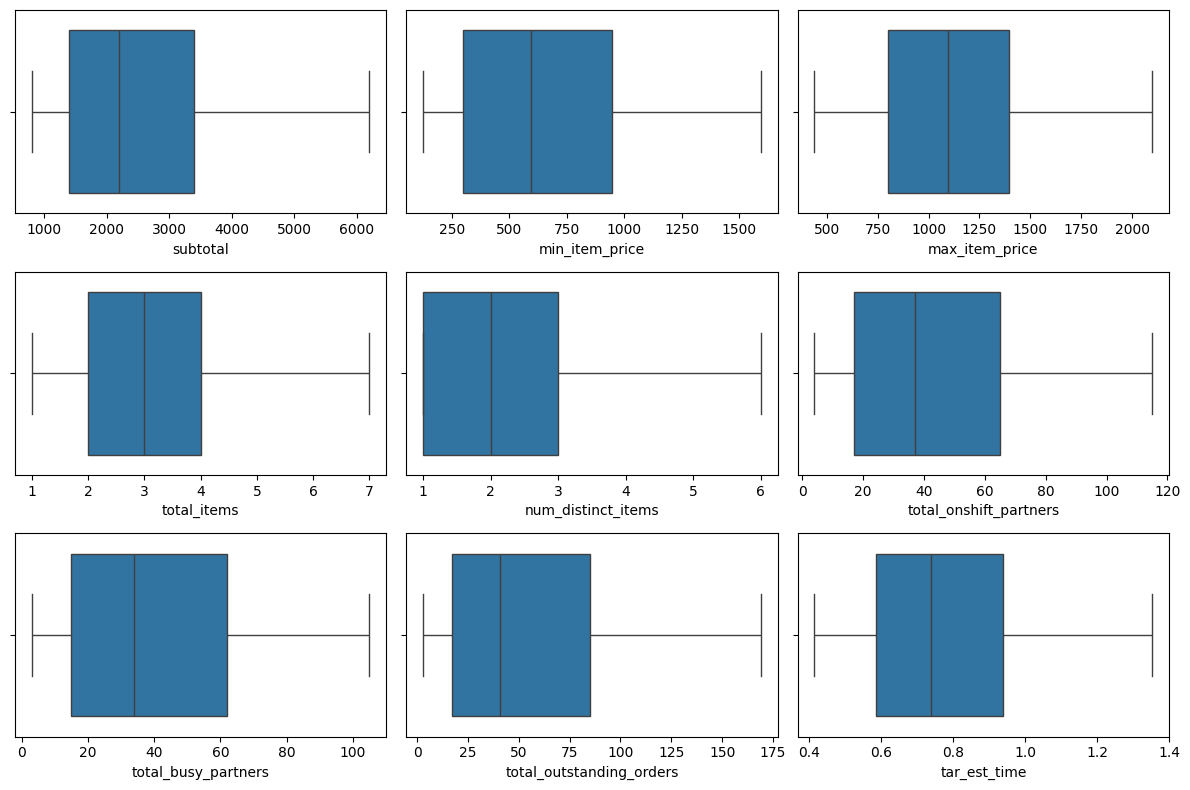

In [29]:
num_cols = ['subtotal', 'min_item_price', 'max_item_price', 'total_items', 'num_distinct_items', 'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders','tar_est_time']

fig, ax = plt.subplots(3,3, figsize = (12,8))

sns.boxplot(ax = ax[0,0], x = df[num_cols[0]])
sns.boxplot(ax = ax[0,1], x = df[num_cols[1]])
sns.boxplot(ax = ax[0,2], x = df[num_cols[2]])
sns.boxplot(ax = ax[1,0], x = df[num_cols[3]])
sns.boxplot(ax = ax[1,1], x = df[num_cols[4]])
sns.boxplot(ax = ax[1,2], x = df[num_cols[5]])
sns.boxplot(ax = ax[2,0], x = df[num_cols[6]])
sns.boxplot(ax = ax[2,1], x = df[num_cols[7]])
sns.boxplot(ax = ax[2,2], x = df[num_cols[8]])
#fig.delaxes(ax[2, 2])

plt.tight_layout()
plt.show()

In [30]:
df['tar_est_time'].describe()

,tar_est_time
count,197421.000000
mean,0.782268
std,0.256451
min,0.414444
25%,0.584444
50%,0.738889
75%,0.939167
max,1.353333


## Binary Variate Analysis
### Observation -
 - Order protocal columns 6id took more delivery time when compared to others
 - New distinct items have high correlation with total itmss and subtotal, vice versa
 - Total onsite partners, total busy partners and total outstanding orders have high correlation with each other

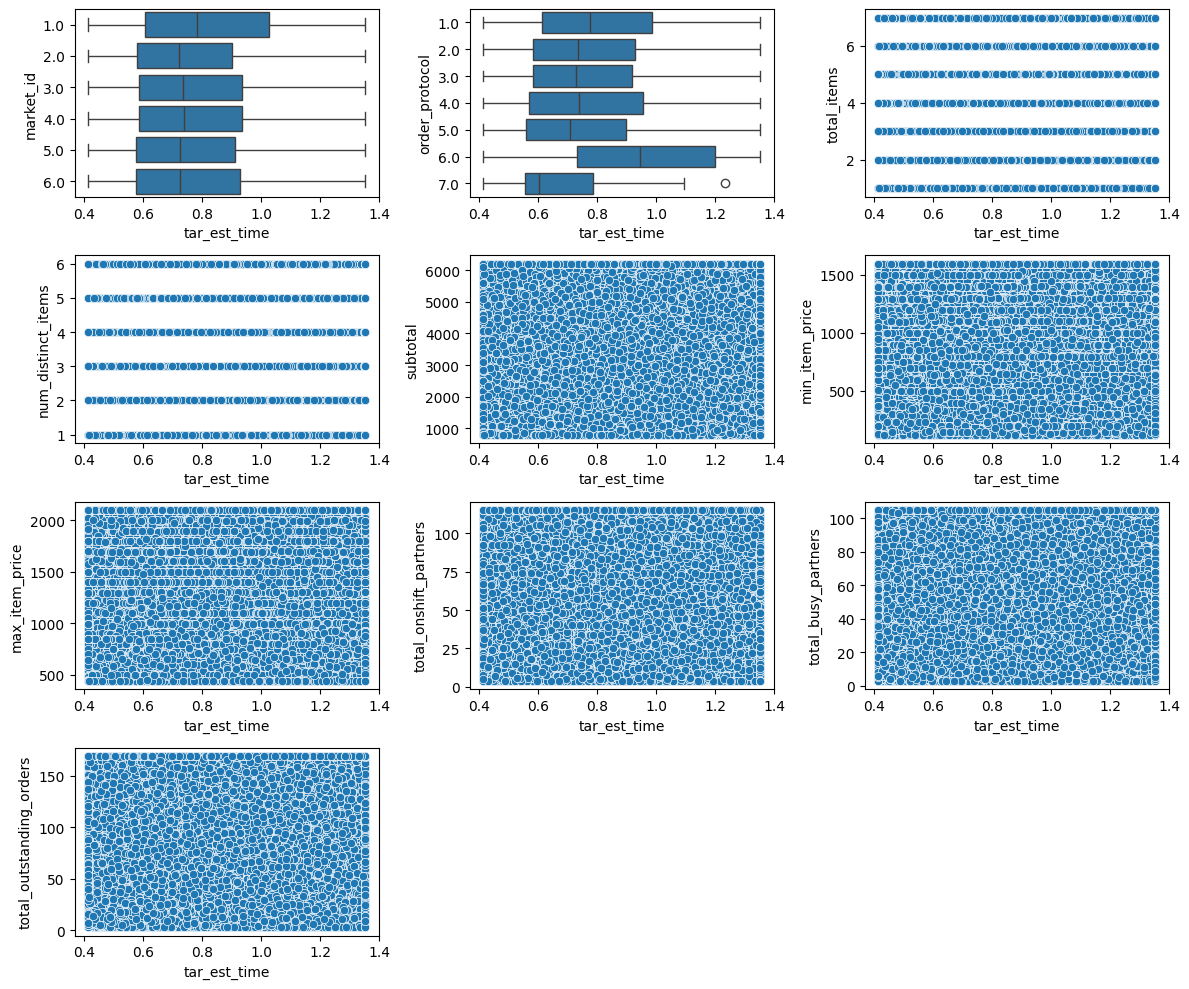

In [11]:
cat_cols = ['market_id', 'order_protocol','total_items', 'num_distinct_items', 'subtotal', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders']

fig, ax = plt.subplots(4,3, figsize = (12,10))

sns.boxplot(ax = ax[0,0], y = df[cat_cols[0]], x = df['tar_est_time'])
sns.boxplot(ax = ax[0,1], y = df[cat_cols[1]], x = df['tar_est_time'])
sns.scatterplot(ax = ax[0,2], y = df[cat_cols[2]], x = df['tar_est_time'])
sns.scatterplot(ax = ax[1,0], y = df[cat_cols[3]], x = df['tar_est_time'])
sns.scatterplot(ax = ax[1,1], y = df[cat_cols[4]], x = df['tar_est_time'])
sns.scatterplot(ax = ax[1,2], y = df[cat_cols[5]], x = df['tar_est_time'])
sns.scatterplot(ax = ax[2,0], y = df[cat_cols[6]], x = df['tar_est_time'])
sns.scatterplot(ax = ax[2,1], y = df[cat_cols[7]], x = df['tar_est_time'])
sns.scatterplot(ax = ax[2,2], y = df[cat_cols[8]], x = df['tar_est_time'])
sns.scatterplot(ax = ax[3,0], y = df[cat_cols[9]], x = df['tar_est_time'])
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
plt.tight_layout()
plt.show()

<Axes: >

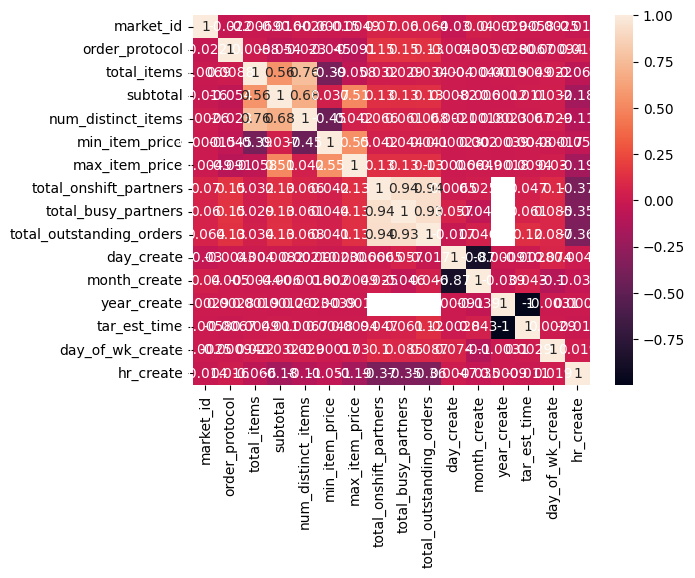

In [34]:
# removed date and columns with text
df1 = df.drop(columns = ['created_at', 'actual_delivery_time', 'store_id','store_primary_category'])
sns.heatmap(df1.corr(method='pearson'), annot=True)

# Data preprocessing
 - Checking duplicates
 - Handling Missing Data
 - Removing the outliers
 - Standardizing Data Formats
 - Feature engineering

## observation found
 - No  duplicates are available
 - outlier are removed in above code
 - Missing values are imputed as below using median, mean and KNN methods
 - Updated columns category data to numerical data by target encoding

In [31]:
# removing duplicates
df1 = df.drop_duplicates()
df1.shape

(197425, 20)

## Handling missing data

In [32]:
# impute missing values
df['market_id'].fillna(value = df['market_id'].mode()[0],  inplace=True)
df['tar_est_time'].fillna(value = df['tar_est_time'].mean(),  inplace=True)
df['order_protocol'].fillna(value = df['order_protocol'].mode()[0],  inplace=True)

<ipython-input-32-1c49bac09702>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['market_id'].fillna(value = df['market_id'].mode()[0],  inplace=True)
<ipython-input-32-1c49bac09702>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [33]:
# using KNN inputation for below columns
knn_imputer = KNNImputer(n_neighbors=3)

# Apply KNN Imputation
df_imputed = knn_imputer.fit_transform(df[['total_onshift_partners','total_busy_partners', 'total_outstanding_orders']])
df_imputed

array([[33., 14., 21.],
       [ 4.,  3.,  3.],
       [ 4.,  3.,  3.],
       ...,
       [39., 41., 40.],
       [ 7.,  7., 12.],
       [20., 20., 23.]])

In [34]:
df_imputed = pd.DataFrame(df_imputed, columns=['total_onshift_partners','total_busy_partners', 'total_outstanding_orders'])
df['total_onshift_partners'] = df_imputed['total_onshift_partners']
df['total_busy_partners'] = df_imputed['total_busy_partners']
df['total_outstanding_orders'] = df_imputed['total_outstanding_orders']

In [35]:
# handling missing values in store_primary_category column
df['store_primary_category'].fillna(value = df['store_primary_category'].mode()[0],  inplace=True)

<ipython-input-35-f3e7e4ad6680>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['store_primary_category'].fillna(value = df['store_primary_category'].mode()[0],  inplace=True)


## Target encodeing of store_primary_category column



In [36]:
# using target encoding
target_means = df.groupby('store_primary_category')['tar_est_time'].mean()
target_means

# Impute missing values in 'Feature' using the target encoding
df['store_primary_category'] = df['store_primary_category'].map(target_means)
df['store_primary_category'] = df['store_primary_category'].astype('int64')

<ipython-input-36-b37aa3f2b64a>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_means = df.groupby('store_primary_category')['tar_est_time'].mean()


# Creating X and y data for training / Val / Test

In [37]:
X = df.drop(columns = ['created_at', 'actual_delivery_time', 'store_id', 'tar_est_time'])
y = df['tar_est_time']

In [38]:
X.shape, y.shape

((197428, 16), (197428,))

# create Train, val and test data

In [39]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

print('Train : ', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)
print('Test  : ', X_test.shape, y_test.shape)

Train :  (159916, 16) (159916,)
Validation: (17769, 16) (17769,)
Test  :  (19743, 16) (19743,)


# Scaling data for training

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# training data

## Iteration 1

In [41]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, concatenate
from tensorflow.keras.models import Model


In [42]:
# define varialb as sequential class
model = Sequential()

model.add(Dense(32, input_dim = 16, activation="relu",kernel_initializer='glorot_uniform')) # 1st hidden layer
model.add(Dense(64, activation="relu",kernel_initializer='glorot_uniform')) # 2nd hidden layer
model.add(Dense(128, activation="relu",kernel_initializer='glorot_uniform')) # 3rd hidden layer
model.add(Dense(64, activation="relu",kernel_initializer='glorot_uniform')) # 4th hidden layer
model.add(Dense(32, activation="relu",kernel_initializer='glorot_uniform')) # 5th hidden layer
model.add(Dense(1)) # output layer by default activation function will be linear activation function

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='mean_squared_error', patience = 3, mode='min')
checkpoint = ModelCheckpoint(filepath='model.h5', save_best_only=True, verbose = 1, monitor='mean_squared_error', mode='min')

In [44]:
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data = (X_val, y_val), callbacks=[early_stopping, checkpoint])

Epoch 1/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0984 - mean_squared_error: 0.0984
Epoch 1: mean_squared_error improved from inf to 0.06622, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0983 - mean_squared_error: 0.0983 - val_loss: 0.0525 - val_mean_squared_error: 0.0525
Epoch 2/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0524 - mean_squared_error: 0.0524
Epoch 2: mean_squared_error improved from 0.06622 to 0.05206, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0524 - mean_squared_error: 0.0524 - val_loss: 0.0520 - val_mean_squared_error: 0.0520
Epoch 3/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 3: mean_squared_error improved from 0.05206 to 0.05138, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - val_loss: 0.0514 - val_mean_squared_error: 0.0514
Epoch 4/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508 - mean_squared_error: 0.0508
Epoch 4: mean_squared_error improved from 0.05138 to 0.05088, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.0512 - val_mean_squared_error: 0.0512
Epoch 5/100
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0502 - mean_squared_error: 0.0502
Epoch 5: mean_squared_error improved from 0.05088 to 0.05045, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0512 - val_mean_squared_error: 0.0512
Epoch 6/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0520 - mean_squared_error: 0.0520
Epoch 6: mean_squared_error did not improve from 0.05045
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0520 - mean_squared_error: 0.0520 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 7/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0504 - mean_squared_error: 0.0504
Epoch 7: mean_squared_error improved from 0.05045 to 0.04990, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0504 - mean_squared_error: 0.0504 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 8/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0497 - mean_squared_error: 0.0497
Epoch 8: mean_squared_error improved from 0.04990 to 0.04962, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0508 - val_mean_squared_error: 0.0508
Epoch 9/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 9: mean_squared_error improved from 0.04962 to 0.04958, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 10/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 10: mean_squared_error improved from 0.04958 to 0.04929, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 11/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 11: mean_squared_error improved from 0.04929 to 0.04908, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Epoch 12/100
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 12: mean_squared_error improved from 0.04908 to 0.04889, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 13/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 13: mean_squared_error improved from 0.04889 to 0.04868, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0493 - val_mean_squared_error: 0.0493
Epoch 14/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 14: mean_squared_error improved from 0.04868 to 0.04855, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0484 - mean_squared_error: 0.0484 - val_loss: 0.0491 - val_mean_squared_error: 0.0491
Epoch 15/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0482 - mean_squared_error: 0.0482
Epoch 15: mean_squared_error improved from 0.04855 to 0.04841, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 16/100
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0480 - mean_squared_error: 0.0480
Epoch 16: mean_squared_error improved from 0.04841 to 0.04812, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 17/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0479 - mean_squared_error: 0.0479
Epoch 17: mean_squared_error improved from 0.04812 to 0.04795, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0493 - val_mean_squared_error: 0.0493
Epoch 18/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0476 - mean_squared_error: 0.0476
Epoch 18: mean_squared_error improved from 0.04795 to 0.04772, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 19/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0475 - mean_squared_error: 0.0475
Epoch 19: mean_squared_error improved from 0.04772 to 0.04760, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0487 - val_mean_squared_error: 0.0487
Epoch 20/100
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0474 - mean_squared_error: 0.0474
Epoch 20: mean_squared_error improved from 0.04760 to 0.04743, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.0488 - val_mean_squared_error: 0.0488
Epoch 21/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0469 - mean_squared_error: 0.0469
Epoch 21: mean_squared_error improved from 0.04743 to 0.04720, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 22/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470 - mean_squared_error: 0.0470
Epoch 22: mean_squared_error improved from 0.04720 to 0.04693, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 23/100
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0468 - mean_squared_error: 0.0468
Epoch 23: mean_squared_error improved from 0.04693 to 0.04668, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 24/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0463 - mean_squared_error: 0.0463
Epoch 24: mean_squared_error improved from 0.04668 to 0.04648, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0481 - val_mean_squared_error: 0.0481
Epoch 25/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0461 - mean_squared_error: 0.0461
Epoch 25: mean_squared_error improved from 0.04648 to 0.04634, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 26/100
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - mean_squared_error: 0.0460
Epoch 26: mean_squared_error improved from 0.04634 to 0.04612, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 27/100
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 - mean_squared_error: 0.0457
Epoch 27: mean_squared_error improved from 0.04612 to 0.04586, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 28/100
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0456 - mean_squared_error: 0.0456
Epoch 28: mean_squared_error improved from 0.04586 to 0.04570, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 29/100
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 - mean_squared_error: 0.0453
Epoch 29: mean_squared_error improved from 0.04570 to 0.04554, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0476 - val_mean_squared_error: 0.0476
Epoch 30/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 - mean_squared_error: 0.0453
Epoch 30: mean_squared_error improved from 0.04554 to 0.04531, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 31/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0451 - mean_squared_error: 0.0451
Epoch 31: mean_squared_error improved from 0.04531 to 0.04515, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 32/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0449 - mean_squared_error: 0.0449
Epoch 32: mean_squared_error improved from 0.04515 to 0.04499, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0475 - val_mean_squared_error: 0.0475
Epoch 33/100
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446 - mean_squared_error: 0.0446
Epoch 33: mean_squared_error improved from 0.04499 to 0.04483, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 34/100
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0444 - mean_squared_error: 0.0444
Epoch 34: mean_squared_error improved from 0.04483 to 0.04476, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0474 - val_mean_squared_error: 0.0474
Epoch 35/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443 - mean_squared_error: 0.0443
Epoch 35: mean_squared_error improved from 0.04476 to 0.04458, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 36/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0442 - mean_squared_error: 0.0442
Epoch 36: mean_squared_error improved from 0.04458 to 0.04449, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 37/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0441 - mean_squared_error: 0.0441
Epoch 37: mean_squared_error improved from 0.04449 to 0.04435, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0481 - val_mean_squared_error: 0.0481
Epoch 38/100
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0442 - mean_squared_error: 0.0442
Epoch 38: mean_squared_error improved from 0.04435 to 0.04423, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0475 - val_mean_squared_error: 0.0475
Epoch 39/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0437 - mean_squared_error: 0.0437
Epoch 39: mean_squared_error improved from 0.04423 to 0.04401, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 40/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438 - mean_squared_error: 0.0438
Epoch 40: mean_squared_error improved from 0.04401 to 0.04390, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 41/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0435 - mean_squared_error: 0.0435
Epoch 41: mean_squared_error improved from 0.04390 to 0.04383, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 42/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0434 - mean_squared_error: 0.0434
Epoch 42: mean_squared_error improved from 0.04383 to 0.04376, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 43/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0433 - mean_squared_error: 0.0433
Epoch 43: mean_squared_error improved from 0.04376 to 0.04358, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 44/100
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0433 - mean_squared_error: 0.0433
Epoch 44: mean_squared_error improved from 0.04358 to 0.04344, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0481 - val_mean_squared_error: 0.0481
Epoch 45/100
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0429 - mean_squared_error: 0.0429
Epoch 45: mean_squared_error improved from 0.04344 to 0.04343, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 46/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0429 - mean_squared_error: 0.0429
Epoch 46: mean_squared_error improved from 0.04343 to 0.04322, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0484 - val_mean_squared_error: 0.0484
Epoch 47/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0431 - mean_squared_error: 0.0431
Epoch 47: mean_squared_error did not improve from 0.04322
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0481 - val_mean_squared_error: 0.0481
Epoch 48/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432 - mean_squared_error: 0.0432
Epoch 48: mean_squared_error improved from 0.04322 to 0.04310, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0481 - val_mean_squared_error: 0.0481
Epoch 49/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0427 - mean_squared_error: 0.0427
Epoch 49: mean_squared_error improved from 0.04310 to 0.04292, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0484 - val_mean_squared_error: 0.0484
Epoch 50/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - mean_squared_error: 0.0426
Epoch 50: mean_squared_error improved from 0.04292 to 0.04282, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 51/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0424 - mean_squared_error: 0.0424
Epoch 51: mean_squared_error improved from 0.04282 to 0.04276, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 52/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0425 - mean_squared_error: 0.0425
Epoch 52: mean_squared_error improved from 0.04276 to 0.04259, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 53/100
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0421 - mean_squared_error: 0.0421
Epoch 53: mean_squared_error improved from 0.04259 to 0.04254, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0484 - val_mean_squared_error: 0.0484
Epoch 54/100
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0420 - mean_squared_error: 0.0420
Epoch 54: mean_squared_error did not improve from 0.04254
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 55/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419 - mean_squared_error: 0.0419
Epoch 55: mean_squared_error improved from 0.04254 to 0.04234, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0487 - val_mean_squared_error: 0.0487
Epoch 56/100
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0422 - mean_squared_error: 0.0422
Epoch 56: mean_squared_error improved from 0.04234 to 0.04230, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 57/100
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0423 - mean_squared_error: 0.0423
Epoch 57: mean_squared_error did not improve from 0.04230
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 58/100
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419 - mean_squared_error: 0.0419
Epoch 58: mean_squared_error improved from 0.04230 to 0.04201, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0487 - val_mean_squared_error: 0.0487
Epoch 59/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0416 - mean_squared_error: 0.0416
Epoch 59: mean_squared_error improved from 0.04201 to 0.04198, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0494 - val_mean_squared_error: 0.0494
Epoch 60/100
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0417 - mean_squared_error: 0.0417
Epoch 60: mean_squared_error improved from 0.04198 to 0.04186, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 61/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0413 - mean_squared_error: 0.0413
Epoch 61: mean_squared_error improved from 0.04186 to 0.04182, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 62/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0413 - mean_squared_error: 0.0413
Epoch 62: mean_squared_error improved from 0.04182 to 0.04171, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 63/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0415 - mean_squared_error: 0.0415
Epoch 63: mean_squared_error improved from 0.04171 to 0.04170, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 64/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0411 - mean_squared_error: 0.0411
Epoch 64: mean_squared_error improved from 0.04170 to 0.04169, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.0491 - val_mean_squared_error: 0.0491
Epoch 65/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0412 - mean_squared_error: 0.0412
Epoch 65: mean_squared_error improved from 0.04169 to 0.04146, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 66/100
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0410 - mean_squared_error: 0.0410
Epoch 66: mean_squared_error improved from 0.04146 to 0.04143, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - val_loss: 0.0493 - val_mean_squared_error: 0.0493
Epoch 67/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0408 - mean_squared_error: 0.0408
Epoch 67: mean_squared_error improved from 0.04143 to 0.04140, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 68/100
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0414 - mean_squared_error: 0.0414
Epoch 68: mean_squared_error improved from 0.04140 to 0.04134, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0494 - val_mean_squared_error: 0.0494
Epoch 69/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0408 - mean_squared_error: 0.0408
Epoch 69: mean_squared_error improved from 0.04134 to 0.04119, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 70/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0409 - mean_squared_error: 0.0409
Epoch 70: mean_squared_error did not improve from 0.04119
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0498 - val_mean_squared_error: 0.0498
Epoch 71/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0414 - mean_squared_error: 0.0414
Epoch 71: mean_squared_error did not improve from 0.04119
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - val_loss: 0.0498 - val_mean_squared_error: 0.0498
Epoch 72/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0408 - mean_squared_error: 0.0408
Epoch 72: mean_squared_error improved from 0.04119 to 0.04095, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0498 - val_mean_squared_error: 0.0498
Epoch 73/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0404 - mean_squared_error: 0.0404
Epoch 73: mean_squared_error improved from 0.04095 to 0.04085, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 74/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0405 - mean_squared_error: 0.0405
Epoch 74: mean_squared_error did not improve from 0.04085
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 75/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0405 - mean_squared_error: 0.0405
Epoch 75: mean_squared_error improved from 0.04085 to 0.04077, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 76/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0403 - mean_squared_error: 0.0403
Epoch 76: mean_squared_error improved from 0.04077 to 0.04061, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0500 - val_mean_squared_error: 0.0500
Epoch 77/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0400 - mean_squared_error: 0.0400
Epoch 77: mean_squared_error improved from 0.04061 to 0.04059, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Epoch 78/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0401 - mean_squared_error: 0.0401
Epoch 78: mean_squared_error improved from 0.04059 to 0.04058, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Epoch 79/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0403 - mean_squared_error: 0.0403
Epoch 79: mean_squared_error improved from 0.04058 to 0.04045, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0499 - val_mean_squared_error: 0.0499
Epoch 80/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0404 - mean_squared_error: 0.0404
Epoch 80: mean_squared_error did not improve from 0.04045
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 81/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0403 - mean_squared_error: 0.0403
Epoch 81: mean_squared_error did not improve from 0.04045
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 82/100
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0399 - mean_squared_error: 0.0399
Epoch 82: mean_squared_error improved from 0.04045 to 0.04029, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 83/100
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0399 - mean_squared_error: 0.0399
Epoch 83: mean_squared_error did not improve from 0.04029
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0505 - val_mean_squared_error: 0.0505
Epoch 84/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0401 - mean_squared_error: 0.0401
Epoch 84: mean_squared_error did not improve from 0.04029
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 85/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0398 - mean_squared_error: 0.0398
Epoch 85: mean_squared_error improved from 0.04029 to 0.04014, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 86/100
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0399 - mean_squared_error: 0.0399
Epoch 86: mean_squared_error improved from 0.04014 to 0.04003, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 87/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0397 - mean_squared_error: 0.0397
Epoch 87: mean_squared_error improved from 0.04003 to 0.04000, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 88/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0398 - mean_squared_error: 0.0398
Epoch 88: mean_squared_error improved from 0.04000 to 0.03990, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 89/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0395 - mean_squared_error: 0.0395
Epoch 89: mean_squared_error improved from 0.03990 to 0.03983, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 90/100
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - mean_squared_error: 0.0392
Epoch 90: mean_squared_error improved from 0.03983 to 0.03978, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0505 - val_mean_squared_error: 0.0505
Epoch 91/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0392 - mean_squared_error: 0.0392
Epoch 91: mean_squared_error improved from 0.03978 to 0.03968, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0509 - val_mean_squared_error: 0.0509
Epoch 92/100
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - mean_squared_error: 0.0392
Epoch 92: mean_squared_error improved from 0.03968 to 0.03967, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0498 - val_mean_squared_error: 0.0498
Epoch 93/100
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0393 - mean_squared_error: 0.0393
Epoch 93: mean_squared_error improved from 0.03967 to 0.03964, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 94/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390 - mean_squared_error: 0.0390
Epoch 94: mean_squared_error improved from 0.03964 to 0.03948, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0390 - mean_squared_error: 0.0390 - val_loss: 0.0513 - val_mean_squared_error: 0.0513
Epoch 95/100
609/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - mean_squared_error: 0.0392
Epoch 95: mean_squared_error did not improve from 0.03948
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0507 - val_mean_squared_error: 0.0507
Epoch 96/100
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0388 - mean_squared_error: 0.0388
Epoch 96: mean_squared_error improved from 0.03948 to 0.03942, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0505 - val_mean_squared_error: 0.0505
Epoch 97/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0388 - mean_squared_error: 0.0388
Epoch 97: mean_squared_error improved from 0.03942 to 0.03936, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 98/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0388 - mean_squared_error: 0.0388
Epoch 98: mean_squared_error improved from 0.03936 to 0.03932, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 99/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0391 - mean_squared_error: 0.0391
Epoch 99: mean_squared_error improved from 0.03932 to 0.03928, saving model to model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0515 - val_mean_squared_error: 0.0515
Epoch 100/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - mean_squared_error: 0.0392
Epoch 100: mean_squared_error did not improve from 0.03928
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0514 - val_mean_squared_error: 0.0514


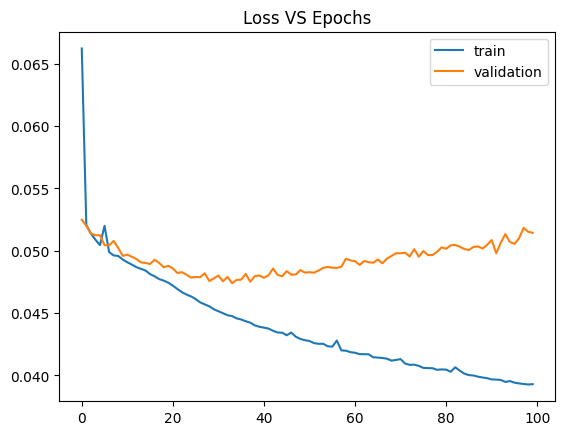

In [45]:
epochs = history.epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]


plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()

In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,037 (250.15 KB)

 Trainable params: 21,345 (83.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,692 (166.77 KB)

In [50]:
from tensorflow.keras.models import load_model
best_model = load_model('model.h5')

pred = best_model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2_score = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
print("Test acc r2_score: ", r2_score)
print("Test acc mse: ", mse)
print("Test acc rmse: ", rmse)
print("Test acc mae: ", mae)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Test acc r2_score:  0.21097258288955967
Test acc mse:  0.051249353985376
Test acc rmse:  0.2263832016413232
Test acc mae:  0.18051552454158223


## Iteration 2

In [54]:
# define varialb as sequential class
model2 = Sequential()

model2.add(Dense(32, input_dim = 16, activation="relu")) # 1st hidden layer
model2.add(Dense(64, activation="relu")) # 2nd hidden layer
model2.add(Dense(128, activation="relu")) # 3rd hidden layer
model2.add(Dense(64, activation="relu")) # 4th hidden layer
model2.add(Dense(32, activation="relu")) # 5th hidden layer
model2.add(Dense(1)) # output layer by default activation function will be linear activation function

model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','r2_score'])

early_stopping_2 = EarlyStopping(monitor='r2_score', patience = 3, mode='max')
checkpoint_2 = ModelCheckpoint(filepath='model_2.h5', save_best_only=True, verbose = 1, monitor='r2_score', mode='max')

history_2 = model2.fit(X_train, y_train, epochs=50, batch_size=256, validation_data = (X_val, y_val), callbacks=[early_stopping_2, checkpoint_2])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0958 - mse: 0.0958 - r2_score: -0.4461
Epoch 1: r2_score improved from -inf to -0.01349, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0952 - mse: 0.0952 - r2_score: -0.4371 - val_loss: 0.0537 - val_mse: 0.0537 - val_r2_score: 0.1758
Epoch 2/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0528 - mse: 0.0528 - r2_score: 0.1997
Epoch 2: r2_score improved from -0.01349 to 0.17359, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0528 - mse: 0.0528 - r2_score: 0.1993 - val_loss: 0.0526 - val_mse: 0.0526 - val_r2_score: 0.1933
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 - mse: 0.0530 - r2_score: 0.1933
Epoch 3: r2_score did not improve from 0.17359
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0531 - mse: 0.0531 - r2_score: 0.1932 - val_loss: 0.0517 - val_mse: 0.0517 - val_r2_score: 0.2071
Epoch 4/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0610 - mse: 0.0610 - r2_score: 0.0724
Epoch 4: r2_score did not improve from 0.17359
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0609 - mse: 0.0609 - r2_score: 0.0736 - val_loss: 0.0512 - val_mse: 0.0512 - val_r2_score: 0.2151
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0510 - mse: 0.0510 - r2_score: 0.2299
Epoch 5: r2_score improved from 0.17359 to 0.22901, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0510 - mse: 0.0510 - r2_score: 0.2299 - val_loss: 0.0504 - val_mse: 0.0504 - val_r2_score: 0.2264
Epoch 6/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0511 - mse: 0.0511 - r2_score: 0.2272
Epoch 6: r2_score improved from 0.22901 to 0.23309, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0511 - mse: 0.0511 - r2_score: 0.2273 - val_loss: 0.0507 - val_mse: 0.0507 - val_r2_score: 0.2223
Epoch 7/50
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0503 - mse: 0.0503 - r2_score: 0.2376
Epoch 7: r2_score improved from 0.23309 to 0.24159, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0502 - mse: 0.0502 - r2_score: 0.2377 - val_loss: 0.0503 - val_mse: 0.0503 - val_r2_score: 0.2290
Epoch 8/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0501 - mse: 0.0501 - r2_score: 0.2423
Epoch 8: r2_score improved from 0.24159 to 0.24352, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0501 - mse: 0.0501 - r2_score: 0.2423 - val_loss: 0.0500 - val_mse: 0.0500 - val_r2_score: 0.2332
Epoch 9/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0494 - mse: 0.0494 - r2_score: 0.2504
Epoch 9: r2_score improved from 0.24352 to 0.24831, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0494 - mse: 0.0494 - r2_score: 0.2504 - val_loss: 0.0499 - val_mse: 0.0499 - val_r2_score: 0.2346
Epoch 10/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0491 - mse: 0.0491 - r2_score: 0.2514
Epoch 10: r2_score did not improve from 0.24831
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0491 - mse: 0.0491 - r2_score: 0.2513 - val_loss: 0.0499 - val_mse: 0.0499 - val_r2_score: 0.2351
Epoch 11/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0493 - mse: 0.0493 - r2_score: 0.2532
Epoch 11: r2_score improved from 0.24831 to 0.25305, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0493 - mse: 0.0493 - r2_score: 0.2532 - val_loss: 0.0497 - val_mse: 0.0497 - val_r2_score: 0.2383
Epoch 12/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0488 - mse: 0.0488 - r2_score: 0.2576
Epoch 12: r2_score improved from 0.25305 to 0.25447, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0488 - mse: 0.0488 - r2_score: 0.2576 - val_loss: 0.0495 - val_mse: 0.0495 - val_r2_score: 0.2406
Epoch 13/50
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0486 - mse: 0.0486 - r2_score: 0.2615
Epoch 13: r2_score improved from 0.25447 to 0.25915, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0486 - mse: 0.0486 - r2_score: 0.2615 - val_loss: 0.0495 - val_mse: 0.0495 - val_r2_score: 0.2411
Epoch 14/50
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0487 - mse: 0.0487 - r2_score: 0.2602
Epoch 14: r2_score improved from 0.25915 to 0.26095, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0487 - mse: 0.0487 - r2_score: 0.2603 - val_loss: 0.0496 - val_mse: 0.0496 - val_r2_score: 0.2393
Epoch 15/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485 - mse: 0.0485 - r2_score: 0.2639
Epoch 15: r2_score improved from 0.26095 to 0.26329, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0485 - mse: 0.0485 - r2_score: 0.2639 - val_loss: 0.0496 - val_mse: 0.0496 - val_r2_score: 0.2391
Epoch 16/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0486 - mse: 0.0486 - r2_score: 0.2607
Epoch 16: r2_score improved from 0.26329 to 0.26481, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0486 - mse: 0.0486 - r2_score: 0.2607 - val_loss: 0.0496 - val_mse: 0.0496 - val_r2_score: 0.2387
Epoch 17/50
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0481 - mse: 0.0481 - r2_score: 0.2670
Epoch 17: r2_score improved from 0.26481 to 0.26701, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0481 - mse: 0.0481 - r2_score: 0.2670 - val_loss: 0.0494 - val_mse: 0.0494 - val_r2_score: 0.2424
Epoch 18/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0478 - mse: 0.0478 - r2_score: 0.2720
Epoch 18: r2_score improved from 0.26701 to 0.26907, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0478 - mse: 0.0478 - r2_score: 0.2720 - val_loss: 0.0492 - val_mse: 0.0492 - val_r2_score: 0.2459
Epoch 19/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0480 - mse: 0.0480 - r2_score: 0.2768
Epoch 19: r2_score improved from 0.26907 to 0.27206, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0480 - mse: 0.0480 - r2_score: 0.2768 - val_loss: 0.0491 - val_mse: 0.0491 - val_r2_score: 0.2473
Epoch 20/50
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0479 - mse: 0.0479 - r2_score: 0.2742
Epoch 20: r2_score improved from 0.27206 to 0.27329, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0479 - mse: 0.0479 - r2_score: 0.2742 - val_loss: 0.0488 - val_mse: 0.0488 - val_r2_score: 0.2511
Epoch 21/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0474 - mse: 0.0474 - r2_score: 0.2769
Epoch 21: r2_score improved from 0.27329 to 0.27517, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0474 - mse: 0.0474 - r2_score: 0.2769 - val_loss: 0.0492 - val_mse: 0.0492 - val_r2_score: 0.2459
Epoch 22/50
610/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0473 - mse: 0.0473 - r2_score: 0.2817
Epoch 22: r2_score improved from 0.27517 to 0.27774, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0473 - mse: 0.0473 - r2_score: 0.2816 - val_loss: 0.0494 - val_mse: 0.0494 - val_r2_score: 0.2417
Epoch 23/50
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0476 - mse: 0.0476 - r2_score: 0.2819
Epoch 23: r2_score improved from 0.27774 to 0.27941, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0476 - mse: 0.0476 - r2_score: 0.2819 - val_loss: 0.0490 - val_mse: 0.0490 - val_r2_score: 0.2488
Epoch 24/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2833
Epoch 24: r2_score improved from 0.27941 to 0.28288, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2833 - val_loss: 0.0489 - val_mse: 0.0489 - val_r2_score: 0.2497
Epoch 25/50
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0471 - mse: 0.0471 - r2_score: 0.2865
Epoch 25: r2_score improved from 0.28288 to 0.28372, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0471 - mse: 0.0471 - r2_score: 0.2865 - val_loss: 0.0491 - val_mse: 0.0491 - val_r2_score: 0.2473
Epoch 26/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0469 - mse: 0.0469 - r2_score: 0.2885
Epoch 26: r2_score improved from 0.28372 to 0.28640, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0469 - mse: 0.0469 - r2_score: 0.2884 - val_loss: 0.0487 - val_mse: 0.0487 - val_r2_score: 0.2531
Epoch 27/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2906
Epoch 27: r2_score improved from 0.28640 to 0.28822, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2906 - val_loss: 0.0486 - val_mse: 0.0486 - val_r2_score: 0.2547
Epoch 28/50
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0472 - mse: 0.0472 - r2_score: 0.2885
Epoch 28: r2_score did not improve from 0.28822
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0472 - mse: 0.0472 - r2_score: 0.2885 - val_loss: 0.0486 - val_mse: 0.0486 - val_r2_score: 0.2543
Epoch 29/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0463 - mse: 0.0463 - r2_score: 0.2984
Epoch 29: r2_score improved from 0.28822 to 0.29398, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0463 - mse: 0.0463 - r2_score: 0.2984 - val_loss: 0.0489 - val_mse: 0.0489 - val_r2_score: 0.2499
Epoch 30/50
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0469 - mse: 0.0469 - r2_score: 0.2853
Epoch 30: r2_score did not improve from 0.29398
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0469 - mse: 0.0469 - r2_score: 0.2853 - val_loss: 0.0488 - val_mse: 0.0488 - val_r2_score: 0.2519
Epoch 31/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0477 - mse: 0.0477 - r2_score: 0.2771
Epoch 31: r2_score did not improve from 0.29398
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0477 - mse: 0.0477 - r2_score: 0.2771 - val_loss: 0.0486 - val_mse: 0.0486 - val_r2_score: 0.2546
Epoch 32/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.3016
Epoch 32: r2_score improved from 0.29398 to 0.29814, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.3015 - val_loss: 0.0491 - val_mse: 0.0491 - val_r2_score: 0.2464
Epoch 33/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.3001
Epoch 33: r2_score improved from 0.29814 to 0.30032, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.3001 - val_loss: 0.0484 - val_mse: 0.0484 - val_r2_score: 0.2574
Epoch 34/50
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3086
Epoch 34: r2_score improved from 0.30032 to 0.30225, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3085 - val_loss: 0.0485 - val_mse: 0.0485 - val_r2_score: 0.2563
Epoch 35/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0455 - mse: 0.0455 - r2_score: 0.3091
Epoch 35: r2_score improved from 0.30225 to 0.30312, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0455 - mse: 0.0455 - r2_score: 0.3090 - val_loss: 0.0484 - val_mse: 0.0484 - val_r2_score: 0.2574
Epoch 36/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0457 - mse: 0.0457 - r2_score: 0.3078
Epoch 36: r2_score improved from 0.30312 to 0.30842, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0457 - mse: 0.0457 - r2_score: 0.3078 - val_loss: 0.0485 - val_mse: 0.0485 - val_r2_score: 0.2561
Epoch 37/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0453 - mse: 0.0453 - r2_score: 0.3115
Epoch 37: r2_score did not improve from 0.30842
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0453 - mse: 0.0453 - r2_score: 0.3115 - val_loss: 0.0483 - val_mse: 0.0483 - val_r2_score: 0.2594
Epoch 38/50
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0451 - mse: 0.0451 - r2_score: 0.3181
Epoch 38: r2_score improved from 0.30842 to 0.31393, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0451 - mse: 0.0451 - r2_score: 0.3180 - val_loss: 0.0489 - val_mse: 0.0489 - val_r2_score: 0.2498
Epoch 39/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0448 - mse: 0.0448 - r2_score: 0.3189
Epoch 39: r2_score improved from 0.31393 to 0.31530, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0448 - mse: 0.0448 - r2_score: 0.3189 - val_loss: 0.0484 - val_mse: 0.0484 - val_r2_score: 0.2577
Epoch 40/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0448 - mse: 0.0448 - r2_score: 0.3199
Epoch 40: r2_score improved from 0.31530 to 0.31729, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0448 - mse: 0.0448 - r2_score: 0.3199 - val_loss: 0.0483 - val_mse: 0.0483 - val_r2_score: 0.2585
Epoch 41/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0447 - mse: 0.0447 - r2_score: 0.3212
Epoch 41: r2_score improved from 0.31729 to 0.31959, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0447 - mse: 0.0447 - r2_score: 0.3212 - val_loss: 0.0485 - val_mse: 0.0485 - val_r2_score: 0.2554
Epoch 42/50
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0444 - mse: 0.0444 - r2_score: 0.3251
Epoch 42: r2_score improved from 0.31959 to 0.32045, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0444 - mse: 0.0444 - r2_score: 0.3250 - val_loss: 0.0483 - val_mse: 0.0483 - val_r2_score: 0.2587
Epoch 43/50
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0442 - mse: 0.0442 - r2_score: 0.3257
Epoch 43: r2_score improved from 0.32045 to 0.32321, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0442 - mse: 0.0442 - r2_score: 0.3256 - val_loss: 0.0486 - val_mse: 0.0486 - val_r2_score: 0.2538
Epoch 44/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0443 - mse: 0.0443 - r2_score: 0.3264
Epoch 44: r2_score improved from 0.32321 to 0.32550, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0443 - mse: 0.0443 - r2_score: 0.3264 - val_loss: 0.0484 - val_mse: 0.0484 - val_r2_score: 0.2569
Epoch 45/50
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0444 - mse: 0.0444 - r2_score: 0.3266
Epoch 45: r2_score improved from 0.32550 to 0.32615, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0444 - mse: 0.0444 - r2_score: 0.3266 - val_loss: 0.0487 - val_mse: 0.0487 - val_r2_score: 0.2533
Epoch 46/50
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443 - mse: 0.0443 - r2_score: 0.3287
Epoch 46: r2_score improved from 0.32615 to 0.32784, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0443 - mse: 0.0443 - r2_score: 0.3287 - val_loss: 0.0486 - val_mse: 0.0486 - val_r2_score: 0.2549
Epoch 47/50
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443 - mse: 0.0443 - r2_score: 0.3284
Epoch 47: r2_score improved from 0.32784 to 0.32857, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0443 - mse: 0.0443 - r2_score: 0.3284 - val_loss: 0.0486 - val_mse: 0.0486 - val_r2_score: 0.2540
Epoch 48/50
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0438 - mse: 0.0438 - r2_score: 0.3335
Epoch 48: r2_score improved from 0.32857 to 0.33124, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0438 - mse: 0.0438 - r2_score: 0.3335 - val_loss: 0.0487 - val_mse: 0.0487 - val_r2_score: 0.2525
Epoch 49/50
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0441 - mse: 0.0441 - r2_score: 0.3339
Epoch 49: r2_score improved from 0.33124 to 0.33215, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0441 - mse: 0.0441 - r2_score: 0.3338 - val_loss: 0.0486 - val_mse: 0.0486 - val_r2_score: 0.2548
Epoch 50/50
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0434 - mse: 0.0434 - r2_score: 0.3414
Epoch 50: r2_score improved from 0.33215 to 0.33456, saving model to model_2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0434 - mse: 0.0434 - r2_score: 0.3413 - val_loss: 0.0486 - val_mse: 0.0486 - val_r2_score: 0.2549


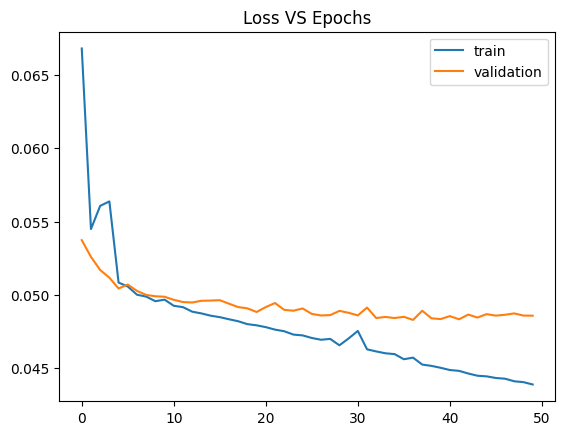

In [55]:
epochs = history_2.epoch
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]


plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()

In [56]:
from tensorflow.keras.models import load_model
best_model = load_model('model_2.h5')

pred = best_model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2_score = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
print("Test acc r2_score: ", r2_score)
print("Test acc mse: ", mse)
print("Test acc rmse: ", rmse)
print("Test acc mae: ", mae)

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test acc r2_score:  0.2686326093250557
Test acc mse:  0.04750418741509285
Test acc rmse:  0.2179545535543886
Test acc mae:  0.1743037704500859


## Iteration 3

In [57]:
# define varialb as sequential class
model3 = Sequential()

model3.add(Dense(32, input_dim = 16, activation="leaky_relu")) # 1st hidden layer
model3.add(Dense(64, activation="leaky_relu")) # 2nd hidden layer
model3.add(Dense(128, activation="leaky_relu")) # 3rd hidden layer
model3.add(Dense(64, activation="leaky_relu")) # 4th hidden layer
model3.add(Dense(32, activation="leaky_relu")) # 5th hidden layer
model3.add(Dense(1)) # output layer by default activation function will be linear activation function

model3.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','r2_score'])

early_stopping_3 = EarlyStopping(monitor='r2_score', patience = 3, mode='max')
checkpoint_3 = ModelCheckpoint(filepath='model_3.h5', save_best_only=True, verbose = 1, monitor='r2_score', mode='max')

history_3 = model3.fit(X_train, y_train, epochs=70, batch_size=256, validation_data = (X_val, y_val), callbacks=[early_stopping_3, checkpoint_3])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1638 - mse: 0.1638 - r2_score: -1.4719
Epoch 1: r2_score improved from -inf to -0.47781, saving model to model_3.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1632 - mse: 0.1632 - r2_score: -1.4640 - val_loss: 0.0530 - val_mse: 0.0530 - val_r2_score: 0.1870
Epoch 2/70
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0530 - mse: 0.0530 - r2_score: 0.1959
Epoch 2: r2_score improved from -0.47781 to 0.20495, saving model to model_3.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0530 - mse: 0.0530 - r2_score: 0.1961 - val_loss: 0.0519 - val_mse: 0.0519 - val_r2_score: 0.2038
Epoch 3/70
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0531 - mse: 0.0531 - r2_score: 0.1933
Epoch 3: r2_score did not improve from 0.20495
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0531 - mse: 0.0531 - r2_score: 0.1934 - val_loss: 0.0512 - val_mse: 0.0512 - val_r2_score: 0.2148
Epoch 4/70
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0590 - mse: 0.0590 - r2_score: 0.1077
Epoch 4: r2_score did not improve from 0.20495
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0590 - mse: 0.0590 - r2_score: 0.1070 - val_loss: 0.0516 - val_mse: 0.0516 - val_r2_score: 0.2082
Epoch 5/70
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0519 - mse: 0.0519 - r2_score: 0.2118
Epoch 5: r2_score improved from 0.20495 to 0.21593, saving model to model_3.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0519 - mse: 0.0519 - r2_score: 0.2119 - val_loss: 0.0507 - val_mse: 0.0507 - val_r2_score: 0.2229
Epoch 6/70
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0529 - mse: 0.0529 - r2_score: 0.1943
Epoch 6: r2_score did not improve from 0.21593
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0529 - mse: 0.0529 - r2_score: 0.1940 - val_loss: 0.0511 - val_mse: 0.0511 - val_r2_score: 0.2161
Epoch 7/70
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0519 - mse: 0.0519 - r2_score: 0.2111
Epoch 7: r2_score did not improve from 0.21593
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0519 - mse: 0.0519 - r2_score: 0.2110 - val_loss: 0.0506 - val_mse: 0.0506 - val_r2_score: 0.2244
Epoch 8/70
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0931 - mse: 0.0931 - r2_score: -0.4108
Epoch 8: r2_score did not improve from 0.21593
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0931 - mse: 0.0931 - r2_score: -0.4111 - val_loss: 0.0504 - 

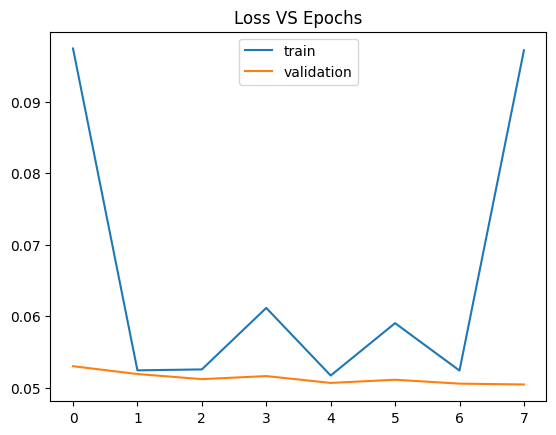

In [58]:
epochs = history_3.epoch
loss = history_3.history["loss"]
val_loss = history_3.history["val_loss"]


plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()

In [59]:
from tensorflow.keras.models import load_model
best_model = load_model('model_3.h5')

pred = best_model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2_score = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
print("Test acc r2_score: ", r2_score)
print("Test acc mse: ", mse)
print("Test acc rmse: ", rmse)
print("Test acc mae: ", mae)

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test acc r2_score:  0.226339651578924
Test acc mse:  0.05025122346937571
Test acc rmse:  0.2241678466448204
Test acc mae:  0.17936568635899341


## Iteratin 4

In [60]:
# define varialb as sequential class
model4 = Sequential()

model4.add(Dense(16, input_dim = 16, activation="leaky_relu")) # 1st hidden layer
model4.add(Dense(32, activation="leaky_relu")) # 2nd hidden layer
model4.add(Dense(64, activation="leaky_relu")) # 3rd hidden layer
model4.add(Dense(128, activation="leaky_relu")) # 4th hidden layer
model4.add(Dense(64, activation="leaky_relu")) # 5th hidden layer
model4.add(Dense(32, activation="leaky_relu")) # 6th hidden layer
model4.add(Dense(16, activation="leaky_relu")) # 7th hidden layer
model4.add(Dense(1)) # output layer by default activation function will be linear activation function

model4.compile(loss='mse', optimizer='adam', metrics=['r2_score'])

model4.fit(X_train, y_train, epochs=20, batch_size=256, validation_data = (X_val, y_val))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0943 - r2_score: -0.4341 - val_loss: 0.0536 - val_r2_score: 0.1784
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0535 - r2_score: 0.1893 - val_loss: 0.0541 - val_r2_score: 0.1707
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0554 - r2_score: 0.1558 - val_loss: 0.0515 - val_r2_score: 0.2102
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0554 - r2_score: 0.1612 - val_loss: 0.0514 - val_r2_score: 0.2109
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0697 - r2_score: -0.0547 - val_loss: 0.0513 - val_r2_score: 0.2133
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0522 - r2_score: 0.2103 - val_loss: 0.0512 - val_r2_score: 0.2148
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0882 - r2_score: -0.3467 - val_loss: 0.0517 - val_r2_score: 0.2067
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0511 - r2_score: 0.2235 - val_loss: 0.0

In [61]:
pred = model4.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2_score = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
print("Test acc r2_score: ", r2_score)
print("Test acc mse: ", mse)
print("Test acc rmse: ", rmse)
print("Test acc mae: ", mae)

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test acc r2_score:  0.23361439463565903
Test acc mse:  0.04977871025376068
Test acc rmse:  0.22311143012799833
Test acc mae:  0.1750757555013447


## Iteration 5

In [65]:
# define varialb as sequential class
from tensorflow.keras.layers import Dense, Dropout
model5 = Sequential()

model5.add(Dense(32, input_dim = 16, activation="tanh")) # 1st hidden layer
Dropout(0.5)
model5.add(Dense(64, activation="leaky_relu")) # 2nd hidden layer
Dropout(0.3)
model5.add(Dense(32, activation="leaky_relu")) # 3rd hidden layer
Dropout(0.2)
model5.add(Dense(1)) # output layer by default activation function will be linear activation function

model5.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','r2_score'])

early_stopping_5 = EarlyStopping(monitor='r2_score', patience = 3, mode='max')
checkpoint_5 = ModelCheckpoint(filepath='model_5.h5', save_best_only=True, verbose = 1, monitor='r2_score', mode='max')

history_5 = model3.fit(X_train, y_train, epochs=70, batch_size=256, validation_data = (X_val, y_val), callbacks=[early_stopping_5, checkpoint_5])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0473 - mse: 0.0473 - r2_score: 0.2840
Epoch 1: r2_score improved from -inf to 0.29227, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0473 - mse: 0.0473 - r2_score: 0.2841 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2779
Epoch 2/70
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.2989
Epoch 2: r2_score improved from 0.29227 to 0.29724, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.2989 - val_loss: 0.0470 - val_mse: 0.0470 - val_r2_score: 0.2792
Epoch 3/70
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3013
Epoch 3: r2_score improved from 0.29724 to 0.29824, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3013 - val_loss: 0.0470 - val_mse: 0.0470 - val_r2_score: 0.2796
Epoch 4/70
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0463 - mse: 0.0463 - r2_score: 0.3031
Epoch 4: r2_score improved from 0.29824 to 0.29868, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0463 - mse: 0.0463 - r2_score: 0.3030 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2768
Epoch 5/70
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462 - mse: 0.0462 - r2_score: 0.2990
Epoch 5: r2_score improved from 0.29868 to 0.29967, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0462 - mse: 0.0462 - r2_score: 0.2990 - val_loss: 0.0470 - val_mse: 0.0470 - val_r2_score: 0.2790
Epoch 6/70
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3002
Epoch 6: r2_score improved from 0.29967 to 0.29976, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3002 - val_loss: 0.0472 - val_mse: 0.0472 - val_r2_score: 0.2758
Epoch 7/70
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0462 - mse: 0.0462 - r2_score: 0.2975
Epoch 7: r2_score did not improve from 0.29976
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0462 - mse: 0.0462 - r2_score: 0.2975 - val_loss: 0.0469 - val_mse: 0.0469 - val_r2_score: 0.2808
Epoch 8/70
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458 - mse: 0.0458 - r2_score: 0.3040
Epoch 8: r2_score improved from 0.29976 to 0.30062, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0458 - mse: 0.0458 - r2_score: 0.3040 - val_loss: 0.0467 - val_mse: 0.0467 - val_r2_score: 0.2831
Epoch 9/70
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3028
Epoch 9: r2_score improved from 0.30062 to 0.30185, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3028 - val_loss: 0.0467 - val_mse: 0.0467 - val_r2_score: 0.2839
Epoch 10/70
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3023
Epoch 10: r2_score improved from 0.30185 to 0.30256, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3023 - val_loss: 0.0474 - val_mse: 0.0474 - val_r2_score: 0.2725
Epoch 11/70
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3049
Epoch 11: r2_score improved from 0.30256 to 0.30310, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3049 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2775
Epoch 12/70
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458 - mse: 0.0458 - r2_score: 0.3027
Epoch 12: r2_score did not improve from 0.30310
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0458 - mse: 0.0458 - r2_score: 0.3027 - val_loss: 0.0469 - val_mse: 0.0469 - val_r2_score: 0.2806
Epoch 13/70
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3054
Epoch 13: r2_score improved from 0.30310 to 0.30371, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3054 - val_loss: 0.0467 - val_mse: 0.0467 - val_r2_score: 0.2842
Epoch 14/70
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458 - mse: 0.0458 - r2_score: 0.3038
Epoch 14: r2_score did not improve from 0.30371
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0458 - mse: 0.0458 - r2_score: 0.3038 - val_loss: 0.0472 - val_mse: 0.0472 - val_r2_score: 0.2766
Epoch 15/70
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0458 - mse: 0.0458 - r2_score: 0.3063
Epoch 15: r2_score did not improve from 0.30371
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0458 - mse: 0.0458 - r2_score: 0.3063 - val_loss: 0.0469 - val_mse: 0.0469 - val_r2_score: 0.2808
Epoch 16/70
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0454 - mse: 0.0454 - r2_score: 0.3070
Epoch 16: r2_score improved from 0.30371 to 0.30491, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0454 - mse: 0.0454 - r2_score: 0.3070 - val_loss: 0.0477 - val_mse: 0.0477 - val_r2_score: 0.2690
Epoch 17/70
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.3016
Epoch 17: r2_score improved from 0.30491 to 0.30499, saving model to model_5.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.3017 - val_loss: 0.0469 - val_mse: 0.0469 - val_r2_score: 0.2801
Epoch 18/70
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3043
Epoch 18: r2_score did not improve from 0.30499
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3043 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2774
Epoch 19/70
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1240 - mse: 0.1240 - r2_score: -0.8801
Epoch 19: r2_score did not improve from 0.30499
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1232 - mse: 0.1232 - r2_score: -0.8680 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2776
Epoch 20/70
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0456 - mse: 0.0456 - r2_score: 0.3074
Epoch 20: r2_score did not improve from 0.30499
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0456 - mse: 0.0456 - r2_score: 0.3074 - val_loss: 0.0

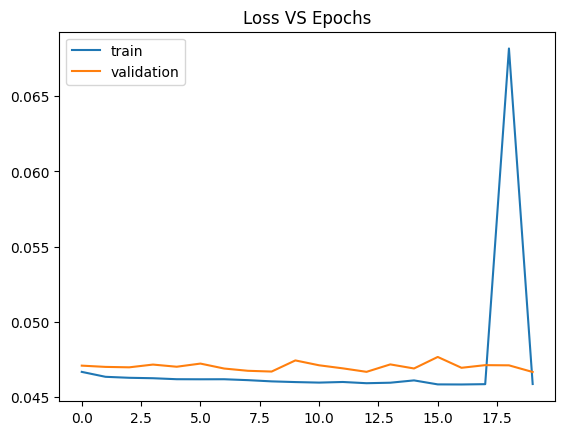

In [66]:
epochs = history_5.epoch
loss = history_5.history["loss"]
val_loss = history_5.history["val_loss"]


plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()

In [67]:
from tensorflow.keras.models import load_model
best_model = load_model('model_5.h5')

pred = best_model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2_score = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
print("Test acc r2_score: ", r2_score)
print("Test acc mse: ", mse)
print("Test acc rmse: ", rmse)
print("Test acc mae: ", mae)

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test acc r2_score:  0.28944548667078973
Test acc mse:  0.04615233766258111
Test acc rmse:  0.21483095136078764
Test acc mae:  0.16977076446846945


## Iteration 6

In [72]:
# define varialb as sequential class
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
model6 = Sequential()

model6.add(Dense(32, input_dim = 16, activation="tanh")) # 1st hidden layer
BatchNormalization()
Dropout(0.5)
model6.add(Dense(64, activation="leaky_relu")) # 2nd hidden layer
BatchNormalization()
Dropout(0.3)
model6.add(Dense(32, activation="leaky_relu")) # 3rd hidden layer
BatchNormalization()
Dropout(0.2)
model6.add(Dense(1)) # output layer by default activation function will be linear activation function

model6.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','r2_score'])

early_stopping_6 = EarlyStopping(monitor='r2_score', patience = 3, mode='max')
checkpoint_6 = ModelCheckpoint(filepath='model_6.h5', save_best_only=True, verbose = 1, monitor='r2_score', mode='max')

history_6 = model6.fit(X_train, y_train, epochs=100, batch_size=256, validation_data = (X_val, y_val), callbacks=[early_stopping_6, checkpoint_6])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1675 - mse: 0.1675 - r2_score: -1.5808
Epoch 1: r2_score improved from -inf to -0.19700, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1655 - mse: 0.1655 - r2_score: -1.5500 - val_loss: 0.0531 - val_mse: 0.0531 - val_r2_score: 0.1861
Epoch 2/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0528 - mse: 0.0528 - r2_score: 0.1956
Epoch 2: r2_score improved from -0.19700 to 0.20223, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0528 - mse: 0.0528 - r2_score: 0.1957 - val_loss: 0.0517 - val_mse: 0.0517 - val_r2_score: 0.2069
Epoch 3/100
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0520 - mse: 0.0520 - r2_score: 0.2139
Epoch 3: r2_score improved from 0.20223 to 0.21641, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0520 - mse: 0.0520 - r2_score: 0.2139 - val_loss: 0.0517 - val_mse: 0.0517 - val_r2_score: 0.2068
Epoch 4/100
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0510 - mse: 0.0510 - r2_score: 0.2245
Epoch 4: r2_score improved from 0.21641 to 0.22219, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0511 - mse: 0.0511 - r2_score: 0.2244 - val_loss: 0.0511 - val_mse: 0.0511 - val_r2_score: 0.2157
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0509 - mse: 0.0509 - r2_score: 0.2285
Epoch 5: r2_score improved from 0.22219 to 0.22719, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0509 - mse: 0.0509 - r2_score: 0.2285 - val_loss: 0.0512 - val_mse: 0.0512 - val_r2_score: 0.2153
Epoch 6/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505 - mse: 0.0505 - r2_score: 0.2343
Epoch 6: r2_score improved from 0.22719 to 0.23075, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0505 - mse: 0.0505 - r2_score: 0.2343 - val_loss: 0.0505 - val_mse: 0.0505 - val_r2_score: 0.2257
Epoch 7/100
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0506 - mse: 0.0506 - r2_score: 0.2328
Epoch 7: r2_score improved from 0.23075 to 0.23471, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0506 - mse: 0.0506 - r2_score: 0.2328 - val_loss: 0.0503 - val_mse: 0.0503 - val_r2_score: 0.2286
Epoch 8/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0502 - mse: 0.0502 - r2_score: 0.2371
Epoch 8: r2_score improved from 0.23471 to 0.23572, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0502 - mse: 0.0502 - r2_score: 0.2371 - val_loss: 0.0501 - val_mse: 0.0501 - val_r2_score: 0.2319
Epoch 9/100
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0504 - mse: 0.0504 - r2_score: 0.2375
Epoch 9: r2_score improved from 0.23572 to 0.23889, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0504 - mse: 0.0504 - r2_score: 0.2375 - val_loss: 0.0504 - val_mse: 0.0504 - val_r2_score: 0.2267
Epoch 10/100
600/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0502 - mse: 0.0502 - r2_score: 0.2386
Epoch 10: r2_score improved from 0.23889 to 0.24106, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0502 - mse: 0.0502 - r2_score: 0.2387 - val_loss: 0.0500 - val_mse: 0.0500 - val_r2_score: 0.2337
Epoch 11/100
605/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0499 - mse: 0.0499 - r2_score: 0.2416
Epoch 11: r2_score improved from 0.24106 to 0.24331, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0499 - mse: 0.0499 - r2_score: 0.2417 - val_loss: 0.0497 - val_mse: 0.0497 - val_r2_score: 0.2369
Epoch 12/100
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0496 - mse: 0.0496 - r2_score: 0.2469
Epoch 12: r2_score improved from 0.24331 to 0.24541, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0496 - mse: 0.0496 - r2_score: 0.2469 - val_loss: 0.0499 - val_mse: 0.0499 - val_r2_score: 0.2339
Epoch 13/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0497 - mse: 0.0497 - r2_score: 0.2460
Epoch 13: r2_score improved from 0.24541 to 0.24672, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0497 - mse: 0.0497 - r2_score: 0.2460 - val_loss: 0.0497 - val_mse: 0.0497 - val_r2_score: 0.2377
Epoch 14/100
618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0496 - mse: 0.0496 - r2_score: 0.2496
Epoch 14: r2_score improved from 0.24672 to 0.24822, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0496 - mse: 0.0496 - r2_score: 0.2496 - val_loss: 0.0504 - val_mse: 0.0504 - val_r2_score: 0.2270
Epoch 15/100
608/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0497 - mse: 0.0497 - r2_score: 0.2488
Epoch 15: r2_score improved from 0.24822 to 0.25065, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0497 - mse: 0.0497 - r2_score: 0.2489 - val_loss: 0.0497 - val_mse: 0.0497 - val_r2_score: 0.2371
Epoch 16/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0490 - mse: 0.0490 - r2_score: 0.2562
Epoch 16: r2_score improved from 0.25065 to 0.25420, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0490 - mse: 0.0490 - r2_score: 0.2562 - val_loss: 0.0494 - val_mse: 0.0494 - val_r2_score: 0.2417
Epoch 17/100
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0488 - mse: 0.0488 - r2_score: 0.2603
Epoch 17: r2_score improved from 0.25420 to 0.25818, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0488 - mse: 0.0488 - r2_score: 0.2603 - val_loss: 0.0489 - val_mse: 0.0489 - val_r2_score: 0.2500
Epoch 18/100
607/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485 - mse: 0.0485 - r2_score: 0.2620
Epoch 18: r2_score improved from 0.25818 to 0.26296, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0485 - mse: 0.0485 - r2_score: 0.2620 - val_loss: 0.0487 - val_mse: 0.0487 - val_r2_score: 0.2529
Epoch 19/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0484 - mse: 0.0484 - r2_score: 0.2655
Epoch 19: r2_score improved from 0.26296 to 0.26704, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0484 - mse: 0.0484 - r2_score: 0.2655 - val_loss: 0.0484 - val_mse: 0.0484 - val_r2_score: 0.2579
Epoch 20/100
605/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0477 - mse: 0.0477 - r2_score: 0.2697
Epoch 20: r2_score improved from 0.26704 to 0.26996, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0477 - mse: 0.0477 - r2_score: 0.2697 - val_loss: 0.0483 - val_mse: 0.0483 - val_r2_score: 0.2586
Epoch 21/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0481 - mse: 0.0481 - r2_score: 0.2731
Epoch 21: r2_score improved from 0.26996 to 0.27257, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0481 - mse: 0.0481 - r2_score: 0.2731 - val_loss: 0.0487 - val_mse: 0.0487 - val_r2_score: 0.2530
Epoch 22/100
607/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0482 - mse: 0.0482 - r2_score: 0.2716
Epoch 22: r2_score improved from 0.27257 to 0.27357, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0482 - mse: 0.0482 - r2_score: 0.2717 - val_loss: 0.0482 - val_mse: 0.0482 - val_r2_score: 0.2605
Epoch 23/100
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0478 - mse: 0.0478 - r2_score: 0.2756
Epoch 23: r2_score improved from 0.27357 to 0.27534, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0478 - mse: 0.0478 - r2_score: 0.2756 - val_loss: 0.0482 - val_mse: 0.0482 - val_r2_score: 0.2609
Epoch 24/100
602/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0477 - mse: 0.0477 - r2_score: 0.2734
Epoch 24: r2_score improved from 0.27534 to 0.27717, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0477 - mse: 0.0477 - r2_score: 0.2735 - val_loss: 0.0490 - val_mse: 0.0490 - val_r2_score: 0.2482
Epoch 25/100
610/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0476 - mse: 0.0476 - r2_score: 0.2785
Epoch 25: r2_score improved from 0.27717 to 0.27727, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0476 - mse: 0.0476 - r2_score: 0.2785 - val_loss: 0.0478 - val_mse: 0.0478 - val_r2_score: 0.2661
Epoch 26/100
620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0474 - mse: 0.0474 - r2_score: 0.2789
Epoch 26: r2_score improved from 0.27727 to 0.28040, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0474 - mse: 0.0474 - r2_score: 0.2789 - val_loss: 0.0480 - val_mse: 0.0480 - val_r2_score: 0.2642
Epoch 27/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0472 - mse: 0.0472 - r2_score: 0.2829
Epoch 27: r2_score improved from 0.28040 to 0.28086, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0473 - mse: 0.0473 - r2_score: 0.2829 - val_loss: 0.0481 - val_mse: 0.0481 - val_r2_score: 0.2625
Epoch 28/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0476 - mse: 0.0476 - r2_score: 0.2806
Epoch 28: r2_score improved from 0.28086 to 0.28168, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0476 - mse: 0.0476 - r2_score: 0.2806 - val_loss: 0.0477 - val_mse: 0.0477 - val_r2_score: 0.2688
Epoch 29/100
610/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0474 - mse: 0.0474 - r2_score: 0.2835
Epoch 29: r2_score improved from 0.28168 to 0.28233, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0474 - mse: 0.0474 - r2_score: 0.2834 - val_loss: 0.0479 - val_mse: 0.0479 - val_r2_score: 0.2648
Epoch 30/100
613/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2876
Epoch 30: r2_score improved from 0.28233 to 0.28383, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2876 - val_loss: 0.0475 - val_mse: 0.0475 - val_r2_score: 0.2709
Epoch 31/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0471 - mse: 0.0471 - r2_score: 0.2858
Epoch 31: r2_score improved from 0.28383 to 0.28472, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0471 - mse: 0.0471 - r2_score: 0.2858 - val_loss: 0.0475 - val_mse: 0.0475 - val_r2_score: 0.2712
Epoch 32/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2869
Epoch 32: r2_score improved from 0.28472 to 0.28531, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2868 - val_loss: 0.0475 - val_mse: 0.0475 - val_r2_score: 0.2713
Epoch 33/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2869
Epoch 33: r2_score did not improve from 0.28531
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2869 - val_loss: 0.0479 - val_mse: 0.0479 - val_r2_score: 0.2646
Epoch 34/100
606/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0471 - mse: 0.0471 - r2_score: 0.2837
Epoch 34: r2_score improved from 0.28531 to 0.28617, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0471 - mse: 0.0471 - r2_score: 0.2838 - val_loss: 0.0476 - val_mse: 0.0476 - val_r2_score: 0.2693
Epoch 35/100
607/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0468 - mse: 0.0468 - r2_score: 0.2894
Epoch 35: r2_score improved from 0.28617 to 0.28688, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0468 - mse: 0.0468 - r2_score: 0.2893 - val_loss: 0.0474 - val_mse: 0.0474 - val_r2_score: 0.2733
Epoch 36/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2885
Epoch 36: r2_score improved from 0.28688 to 0.28855, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2885 - val_loss: 0.0474 - val_mse: 0.0474 - val_r2_score: 0.2722
Epoch 37/100
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0469 - mse: 0.0469 - r2_score: 0.2911
Epoch 37: r2_score improved from 0.28855 to 0.28942, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0469 - mse: 0.0469 - r2_score: 0.2910 - val_loss: 0.0474 - val_mse: 0.0474 - val_r2_score: 0.2734
Epoch 38/100
601/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0471 - mse: 0.0471 - r2_score: 0.2911
Epoch 38: r2_score improved from 0.28942 to 0.28980, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0471 - mse: 0.0471 - r2_score: 0.2910 - val_loss: 0.0476 - val_mse: 0.0476 - val_r2_score: 0.2693
Epoch 39/100
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0469 - mse: 0.0469 - r2_score: 0.2875
Epoch 39: r2_score improved from 0.28980 to 0.29008, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0469 - mse: 0.0469 - r2_score: 0.2876 - val_loss: 0.0475 - val_mse: 0.0475 - val_r2_score: 0.2707
Epoch 40/100
602/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0464 - mse: 0.0464 - r2_score: 0.2909
Epoch 40: r2_score improved from 0.29008 to 0.29077, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0465 - mse: 0.0465 - r2_score: 0.2909 - val_loss: 0.0476 - val_mse: 0.0476 - val_r2_score: 0.2705
Epoch 41/100
609/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2882
Epoch 41: r2_score did not improve from 0.29077
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0469 - mse: 0.0469 - r2_score: 0.2882 - val_loss: 0.0473 - val_mse: 0.0473 - val_r2_score: 0.2740
Epoch 42/100
605/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0466 - mse: 0.0466 - r2_score: 0.2905
Epoch 42: r2_score improved from 0.29077 to 0.29167, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0467 - mse: 0.0467 - r2_score: 0.2906 - val_loss: 0.0474 - val_mse: 0.0474 - val_r2_score: 0.2724
Epoch 43/100
609/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2895
Epoch 43: r2_score did not improve from 0.29167
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0470 - mse: 0.0470 - r2_score: 0.2895 - val_loss: 0.0474 - val_mse: 0.0474 - val_r2_score: 0.2728
Epoch 44/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0468 - mse: 0.0468 - r2_score: 0.2911
Epoch 44: r2_score did not improve from 0.29167
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0468 - mse: 0.0468 - r2_score: 0.2911 - val_loss: 0.0475 - val_mse: 0.0475 - val_r2_score: 0.2713
Epoch 45/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0465 - mse: 0.0465 - r2_score: 0.2950
Epoch 45: r2_score improved from 0.29167 to 0.29293, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0465 - mse: 0.0465 - r2_score: 0.2950 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2769
Epoch 46/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0466 - mse: 0.0466 - r2_score: 0.2887
Epoch 46: r2_score did not improve from 0.29293
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0466 - mse: 0.0466 - r2_score: 0.2887 - val_loss: 0.0476 - val_mse: 0.0476 - val_r2_score: 0.2704
Epoch 47/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467 - mse: 0.0467 - r2_score: 0.2939
Epoch 47: r2_score improved from 0.29293 to 0.29345, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0467 - mse: 0.0467 - r2_score: 0.2939 - val_loss: 0.0475 - val_mse: 0.0475 - val_r2_score: 0.2715
Epoch 48/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0464 - mse: 0.0464 - r2_score: 0.2920
Epoch 48: r2_score improved from 0.29345 to 0.29374, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0464 - mse: 0.0464 - r2_score: 0.2920 - val_loss: 0.0469 - val_mse: 0.0469 - val_r2_score: 0.2810
Epoch 49/100
607/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0464 - mse: 0.0464 - r2_score: 0.3007
Epoch 49: r2_score improved from 0.29374 to 0.29416, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0464 - mse: 0.0464 - r2_score: 0.3005 - val_loss: 0.0473 - val_mse: 0.0473 - val_r2_score: 0.2741
Epoch 50/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0464 - mse: 0.0464 - r2_score: 0.2924
Epoch 50: r2_score improved from 0.29416 to 0.29476, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0464 - mse: 0.0464 - r2_score: 0.2925 - val_loss: 0.0472 - val_mse: 0.0472 - val_r2_score: 0.2766
Epoch 51/100
609/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0463 - mse: 0.0463 - r2_score: 0.2973
Epoch 51: r2_score did not improve from 0.29476
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0463 - mse: 0.0463 - r2_score: 0.2972 - val_loss: 0.0474 - val_mse: 0.0474 - val_r2_score: 0.2735
Epoch 52/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0462 - mse: 0.0462 - r2_score: 0.2985
Epoch 52: r2_score improved from 0.29476 to 0.29632, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0462 - mse: 0.0462 - r2_score: 0.2985 - val_loss: 0.0479 - val_mse: 0.0479 - val_r2_score: 0.2657
Epoch 53/100
601/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467 - mse: 0.0467 - r2_score: 0.2938
Epoch 53: r2_score did not improve from 0.29632
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0467 - mse: 0.0467 - r2_score: 0.2939 - val_loss: 0.0473 - val_mse: 0.0473 - val_r2_score: 0.2746
Epoch 54/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0462 - mse: 0.0462 - r2_score: 0.2988
Epoch 54: r2_score improved from 0.29632 to 0.29690, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0462 - mse: 0.0462 - r2_score: 0.2988 - val_loss: 0.0469 - val_mse: 0.0469 - val_r2_score: 0.2807
Epoch 55/100
607/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.2989
Epoch 55: r2_score did not improve from 0.29690
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.2989 - val_loss: 0.0474 - val_mse: 0.0474 - val_r2_score: 0.2727
Epoch 56/100
610/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3013
Epoch 56: r2_score improved from 0.29690 to 0.29709, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3012 - val_loss: 0.0472 - val_mse: 0.0472 - val_r2_score: 0.2763
Epoch 57/100
605/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.2983
Epoch 57: r2_score did not improve from 0.29709
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.2982 - val_loss: 0.0473 - val_mse: 0.0473 - val_r2_score: 0.2741
Epoch 58/100
610/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0464 - mse: 0.0464 - r2_score: 0.2973
Epoch 58: r2_score improved from 0.29709 to 0.29833, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0464 - mse: 0.0464 - r2_score: 0.2974 - val_loss: 0.0473 - val_mse: 0.0473 - val_r2_score: 0.2747
Epoch 59/100
614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0463 - mse: 0.0463 - r2_score: 0.2989
Epoch 59: r2_score improved from 0.29833 to 0.29904, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0463 - mse: 0.0463 - r2_score: 0.2989 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2775
Epoch 60/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3015
Epoch 60: r2_score did not improve from 0.29904
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.3015 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2769
Epoch 61/100
615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3013
Epoch 61: r2_score improved from 0.29904 to 0.29919, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3013 - val_loss: 0.0470 - val_mse: 0.0470 - val_r2_score: 0.2790
Epoch 62/100
616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3005
Epoch 62: r2_score did not improve from 0.29919
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3005 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2775
Epoch 63/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.2998
Epoch 63: r2_score did not improve from 0.29919
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.2998 - val_loss: 0.0474 - val_mse: 0.0474 - val_r2_score: 0.2728
Epoch 64/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.3007
Epoch 64: r2_score improved from 0.29919 to 0.30017, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.3007 - val_loss: 0.0473 - val_mse: 0.0473 - val_r2_score: 0.2750
Epoch 65/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3022
Epoch 65: r2_score improved from 0.30017 to 0.30058, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3022 - val_loss: 0.0470 - val_mse: 0.0470 - val_r2_score: 0.2783
Epoch 66/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0457 - mse: 0.0457 - r2_score: 0.3058
Epoch 66: r2_score improved from 0.30058 to 0.30139, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0457 - mse: 0.0457 - r2_score: 0.3057 - val_loss: 0.0467 - val_mse: 0.0467 - val_r2_score: 0.2834
Epoch 67/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3028
Epoch 67: r2_score improved from 0.30139 to 0.30152, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3028 - val_loss: 0.0469 - val_mse: 0.0469 - val_r2_score: 0.2806
Epoch 68/100
611/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458 - mse: 0.0458 - r2_score: 0.3034
Epoch 68: r2_score improved from 0.30152 to 0.30190, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0458 - mse: 0.0458 - r2_score: 0.3033 - val_loss: 0.0472 - val_mse: 0.0472 - val_r2_score: 0.2761
Epoch 69/100
607/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3023
Epoch 69: r2_score did not improve from 0.30190
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0460 - mse: 0.0460 - r2_score: 0.3023 - val_loss: 0.0470 - val_mse: 0.0470 - val_r2_score: 0.2793
Epoch 70/100
605/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3048
Epoch 70: r2_score improved from 0.30190 to 0.30236, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3047 - val_loss: 0.0473 - val_mse: 0.0473 - val_r2_score: 0.2744
Epoch 71/100
606/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0457 - mse: 0.0457 - r2_score: 0.3061
Epoch 71: r2_score improved from 0.30236 to 0.30349, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0457 - mse: 0.0457 - r2_score: 0.3061 - val_loss: 0.0467 - val_mse: 0.0467 - val_r2_score: 0.2844
Epoch 72/100
617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0454 - mse: 0.0454 - r2_score: 0.3070
Epoch 72: r2_score did not improve from 0.30349
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0454 - mse: 0.0454 - r2_score: 0.3069 - val_loss: 0.0469 - val_mse: 0.0469 - val_r2_score: 0.2804
Epoch 73/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3052
Epoch 73: r2_score improved from 0.30349 to 0.30354, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0459 - mse: 0.0459 - r2_score: 0.3051 - val_loss: 0.0469 - val_mse: 0.0469 - val_r2_score: 0.2803
Epoch 74/100
605/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0457 - mse: 0.0457 - r2_score: 0.3045
Epoch 74: r2_score improved from 0.30354 to 0.30401, saving model to model_6.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0457 - mse: 0.0457 - r2_score: 0.3045 - val_loss: 0.0469 - val_mse: 0.0469 - val_r2_score: 0.2802
Epoch 75/100
612/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.2994
Epoch 75: r2_score did not improve from 0.30401
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0461 - mse: 0.0461 - r2_score: 0.2995 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2781
Epoch 76/100
601/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0457 - mse: 0.0457 - r2_score: 0.3070
Epoch 76: r2_score did not improve from 0.30401
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0457 - mse: 0.0457 - r2_score: 0.3069 - val_loss: 0.0471 - val_mse: 0.0471 - val_r2_score: 0.2781
Epoch 77/100
607/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0462 - mse: 0.0462 - r2_score: 0.2999
Epoch 77: r2_score did not improve from 0.30401
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0462 - mse: 0.0462 - r2_score: 0.3000 - val_loss: 0.

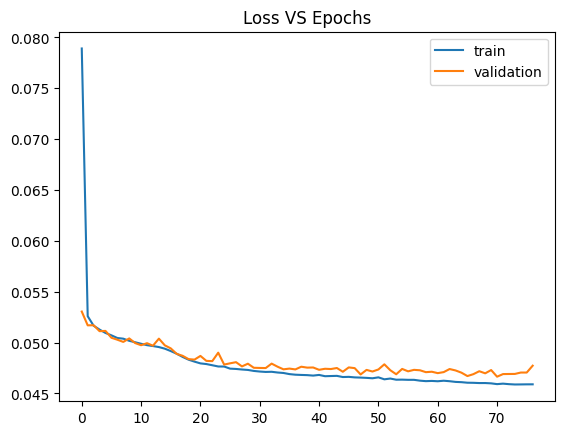

In [73]:
epochs = history_6.epoch
loss = history_6.history["loss"]
val_loss = history_6.history["val_loss"]


plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()

In [74]:
from tensorflow.keras.models import load_model
best_model = load_model('model_6.h5')

pred = best_model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2_score = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
print("Test acc r2_score: ", r2_score)
print("Test acc mse: ", mse)
print("Test acc rmse: ", rmse)
print("Test acc mae: ", mae)

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
Test acc r2_score:  0.2862416394971815
Test acc mse:  0.046360435751892894
Test acc rmse:  0.2153147364949573
Test acc mae:  0.17155365738282108


## Iternation 7
 - l1/l2 regularization

In [75]:
def create_baseline():
    # lambda = 0.01
    L2Reg = tf.keras.regularizers.L2(l2=1e-6)
    model = Sequential([
                    Dense(256, activation="relu", kernel_regularizer = L2Reg ),
                    Dense(128, activation="relu", kernel_regularizer = L2Reg),
                    Dense(64, activation="relu", kernel_regularizer = L2Reg),
                    Dense(1 , activation = 'sigmoid')])
    return model


model_7 = create_baseline()

model_7.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics=["accuracy"])


history = model_7.fit(X_train, y_train, validation_data = (X_val, y_val),  epochs=30, batch_size=128, verbose=1)


Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 2.4967e-04 - loss: -1.0173 - val_accuracy: 2.2511e-04 - val_loss: -41.9929
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.6038e-04 - loss: -149.2995 - val_accuracy: 2.2511e-04 - val_loss: -1070.5962
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.3933e-04 - loss: -2344.5378 - val_accuracy: 1.6883e-04 - val_loss: -6482.5005
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.6003e-04 - loss: -11008.8604 - val_accuracy: 2.2511e-04 - val_loss: -19654.2344
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.6434e-04 - loss: -32389.1484 - val_accuracy: 2.2511e-04 - val_loss: -45693.8750
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.1630e-04 - loss: -68516.1875 - val_accuracy: 1.6883e-04 - val_loss: -87619.6484
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.4429e-04 - loss: -124107.8438 - val_accuracy: 1.6883e-04

In [76]:
pred = model_7.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2_score = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
print("Test acc r2_score: ", r2_score)
print("Test acc mse: ", mse)
print("Test acc rmse: ", rmse)
print("Test acc mae: ", mae)

617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test acc r2_score:  -0.7330571163783237
Test acc mse:  0.11256650365764893
Test acc rmse:  0.33550931977763143
Test acc mae:  0.2929052350481465


# Summary of all iteration
## R2_score are mentioned below
 - Iter1 --> 0.210 (with kernal intializers and 5 hidden layers)
 - Iter2 --> 0.268 (with only 5 hidden layers)
 - Iter3--> 0.226 (with leaky relu activation function and 5 hidden layers)
 - Iter4 --> 0.23 (with leaky relu and 7 hidden layer)
 - Iter5 --> 0.289 (with drop out with 3 hidden layers)
 - Iter6 -->  0.286 (with dropout and batch normalization with 3 hidden layers)
 - Iter7 --> -0.733 (with regularization)

# Best option are having dropout and batch normalization with more hidden layers -  best model

# Leading Questions:

1. Defining the problem statements and where can this and modifications of this be used?
 - Porter has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.

2. List 3 functions the pandas datetime provides with one line explanation.
 - to_datetime(): Converts strings or timestamps
 - date_range(): Creates a sequence of dates or times over a specified range
 - dt.weekday: Extracts the day of the week

3. Short note on datetime, timedelta, time span (period)
 - Datetime includes year, month, day, hours, minutes and seconds eg - 2014-10-19 05:24:15
 - timedelta --> there is no specific difference between two dates some are in hours and some days are difference,
 - Time span --> data includes range from 2014-10-19 05:24:15 to 2015-02-18 06:00:44 at created_at column (order date and time)

4. Why do we need to check for outliers in our data?
 - outlier creates problem is learning, where outlier shows data which is not normal. But model should be learnt on trend and patterns.
 - with removal of outlier, model will more efficient and reliable for predicion

5. Name 3 outlier removal methods?
 - using Interquartile Range, to remove exterme or data points below 5 percetile and above 95 percentile.
 - by using Box Plot or Scatter Plot to identify and remove outlier.
 - by Isolation Forest, to detect and remove outliers
 - DBSCAN method to remove outlier

6. What classical machine learning methods can we use for this problem?
 - Linear Regression, Polynomial Regression, Support Vector Regression (SVR), Decision Tree, Random Forest

7. Why is scaling required for neural networks?
 - scaling helps the neural network learn patterns efficiently and equal weightage are given to features for training

8. Briefly explain your choice of optimizer.
- Adma optimizer is consider instead of any other SGD, where adan controls learning and induces monmentum, so saddle point and local minima can be escaped to reach global minima

9. Which activation function did you use and why?
- Relu activation function, this activation function doesn't have vanishing gradient issue when compared to tanh and sigmoid function

10. Why does a neural network perform well on a large dataset?
- large datasets provides neural networks more information to learn and enabling them to model to learn complex patterns and deliver high performance when compared to others models